In [1]:
#cell 0 同步git

# 1克隆整个 GitHub 仓库 
!rm -rf GM-EPC
!git clone https://github.com/dujue55/GM-EPC.git

# === 查看项目结构是否成功 ===
!ls GM-EPC
!ls GM-EPC/src

Cloning into 'GM-EPC'...
remote: Enumerating objects: 326, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 326 (delta 80), reused 79 (delta 40), pack-reused 207 (from 1)
Receiving objects: 100% (326/326), 86.51 KiB | 1.97 MiB/s, done.
Resolving deltas: 100% (214/214), done.
notebooks  requirements-local.txt  requirements.txt  src
dataset.py  features.py  __init__.py  model.py	readme.txt  trainer.py	utils


In [2]:
# ----------------------------------------------------
# Cell 1: 初始化、同步和依赖安装 (Kaggle 优化版)
# ----------------------------------------------------

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# --- 1. 定义仓库名称 ---
GIT_REPO_NAME = "GM-EPC"

# --- 2. 添加路径和安装依赖 ---
# 使用 os.path.join 确保跨平台兼容性
SRC_PATH = os.path.abspath(os.path.join(GIT_REPO_NAME, 'src')) 
REQUIREMENTS_PATH = os.path.join(GIT_REPO_NAME, 'requirements.txt')

if not os.path.exists(SRC_PATH):
    print("FATAL ERROR: GM-EPC 仓库未找到。请检查 Cell 0 的克隆路径是否正确。")
    sys.exit(1)

if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
    
print(f"本地模块路径 '{SRC_PATH}' 已添加到系统路径。")


# --- 4. 安装项目依赖 (仅安装上层库，接受底层预装) ---

print("\n--- 正在安装项目依赖---")

# 4a. 强制降级不兼容的核心依赖 (tokenizers)
# transformers==4.36.2 要求 tokenizers 在 <0.19 范围内

!pip install tokenizers==0.15.2 --force-reinstall --quiet

# 4b. 安装其余的项目依赖 (继续使用 --no-deps 保护环境)
!pip install -r {REQUIREMENTS_PATH} --no-deps --quiet

# --- 5. 验证环境 ---
import torch
print("\n--- 环境验证 ---")
print(f"Python 路径已包含 src: {SRC_PATH in sys.path}")
print(f"GPU Status: {'✅ CUDA 可用' if torch.cuda.is_available() else '❌ CPU 模式 (请开启加速器)'}")



本地模块路径 '/kaggle/working/GM-EPC/src' 已添加到系统路径。

--- 正在安装项目依赖---
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/1

In [3]:
# Cell 2: 版本检查
print("--- 检查核心依赖版本 ---")
!pip show transformers | grep Version
!pip show tokenizers | grep Version
!pip show funasr | grep Version

--- 检查核心依赖版本 ---
Version: 4.36.2
Version: 0.15.2
Version: 1.0.21


In [5]:
# Cell 3: 特征提取执行 

import numpy as np
import time
import os
import torch
from features import load_feature_extractors, extract_single_feature
from dataset import IEMOCAPDataset 
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# --- 1. 定义设备和配置 ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

KAGGLE_DATA_ROOT = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release'
# FEATURE_CACHE_DIR = './GM-EPC/data/features_cache' 
FEATURE_CACHE_DIR = './GM-EPC/data/features_cache_e2v_base'
#FEATURE_CACHE_DIR = './GM-EPC/data/features_cache_e2v_seed'


os.makedirs(FEATURE_CACHE_DIR, exist_ok=True)
FEATURE_CONFIG = {'history_len': 3}


# --- 1. 在循环外只初始化一次 Dataset，使用 Dummy Target---
dataset = IEMOCAPDataset(
    data_root=KAGGLE_DATA_ROOT, 
    target_session='Session1', # 使用 Session1 作为 Dummy Target，确保 raw_utterances_by_session 被加载
    is_train=True, 
    history_len=FEATURE_CONFIG['history_len']
)

# --- 2. 通用特征提取函数 ---
def run_feature_extraction_process(data_root, config, mode):
    print(f"\n=== 🚀 Stage: {mode.upper()} 特征提取开始 ===")
    
    # 加载模型
    load_feature_extractors(DEVICE, mode=mode)
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()
    
    sessions = [f'Session{i}' for i in range(1, 6)]
    all_extraction_time = time.time()

    # 注意：dataset 在函数外部被初始化，并被复用
    
    for session_name in sessions:
        start_time = time.time()
        print(f"\n--- 🚀 提取 {session_name} ({mode}) ---")

        # 将缓存列表定义在 Session 循环内部
        utt_ids_cache = []
        F_t_cache, F_s_e2v_cache, F_s_wavlm_cache = [], [], []

        raw_utterances = dataset.raw_utterances_by_session[session_name]
        
        for utt in tqdm(raw_utterances, desc=f"{session_name} ({mode})"):
            
            # 提取特征
            F_t, F_s_e2v, F_s_wavlm = extract_single_feature([utt["text"]], [utt["audio_path"]])
            
            # 简化提取逻辑（利用 extract_single_feature 始终返回零向量的特性）
            F_t_cache.append(F_t.squeeze(0).cpu().numpy())
            F_s_e2v_cache.append(F_s_e2v.squeeze(0).cpu().numpy())
            F_s_wavlm_cache.append(F_s_wavlm.squeeze(0).cpu().numpy())
            utt_ids_cache.append(utt["utt_id"])


        # 3. 保存特征
        F_t_array = np.array(F_t_cache, dtype=np.float32)
        F_s_e2v_array = np.array(F_s_e2v_cache, dtype=np.float32)
        F_s_wavlm_array = np.array(F_s_wavlm_cache, dtype=np.float32)

        # 3.1 保存逻辑 (只保存当前 mode 的有效特征)
        if mode == 'text':
            np.save(os.path.join(FEATURE_CACHE_DIR, f"{session_name}_F_t.npy"), F_t_array)
            np.save(os.path.join(FEATURE_CACHE_DIR, f"{session_name}_utt_ids.npy"), np.array(utt_ids_cache))
        elif mode == 'e2v':
            np.save(os.path.join(FEATURE_CACHE_DIR, f"{session_name}_F_s_e2v.npy"), F_s_e2v_array)
        elif mode == 'wavlm':
            np.save(os.path.join(FEATURE_CACHE_DIR, f"{session_name}_F_s_wavlm.npy"), F_s_wavlm_array)

        print(f"✅ {session_name} ({mode}) 完成，样本数: {len(utt_ids_cache)} | 耗时: {time.time() - start_time:.2f}s")
        
        # 释放内存
        del F_t_array, F_s_e2v_array, F_s_wavlm_array
        if DEVICE.type == 'cuda':
            torch.cuda.empty_cache()

    print(f"\n=== ✅ {mode.upper()} 模式提取完成，总耗时 {(time.time()-all_extraction_time)/60:.2f} 分钟 ===")


# --- 3. 三阶段运行 ---
run_feature_extraction_process(KAGGLE_DATA_ROOT, FEATURE_CONFIG, mode='text')
run_feature_extraction_process(KAGGLE_DATA_ROOT, FEATURE_CONFIG, mode='e2v')
run_feature_extraction_process(KAGGLE_DATA_ROOT, FEATURE_CONFIG, mode='wavlm')

If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
Using device: cuda
Processing sessions: ['Session2', 'Session3', 'Session4', 'Session5']
Loaded Train samples: 4444 for target session Session1

=== 🚀 Stage: TEXT 特征提取开始 ===
Loading feature extractors to device: cuda in mode: text...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✅ BERT Text Model loaded.
Current active models: T:True, E2V:False, WLM:False
Feature extractors loading process finished. Be aware of potential OOM issues when running all models on GPU.

--- 🚀 提取 Session1 (text) ---


Session1 (text):   0%|          | 0/1807 [00:00<?, ?it/s]

✅ Session1 (text) 完成，样本数: 1807 | 耗时: 17.84s

--- 🚀 提取 Session2 (text) ---


Session2 (text):   0%|          | 0/1802 [00:00<?, ?it/s]

KeyboardInterrupt: 

🔬 启动特征完整性检查 (Feature Integrity Check)

[检查 Session1]
🧩 当前检查特征类型: emotion2vec (e2v)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5315) | F_s (e2v) (Mean=0.0168, Std=0.9728)
✅ Session1 (e2v) 通过结构和内容检查。


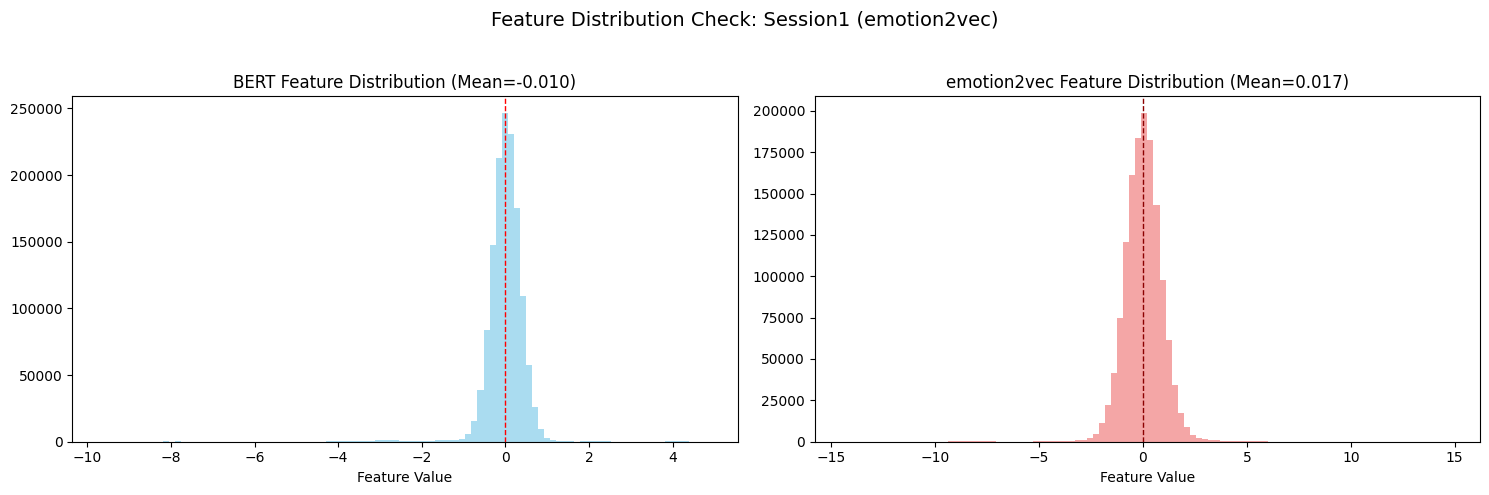

🧩 当前检查特征类型: wavlm (wavlm)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5315) | F_s (wavlm) (Mean=0.0046, Std=0.0868)
✅ Session1 (wavlm) 通过结构和内容检查。


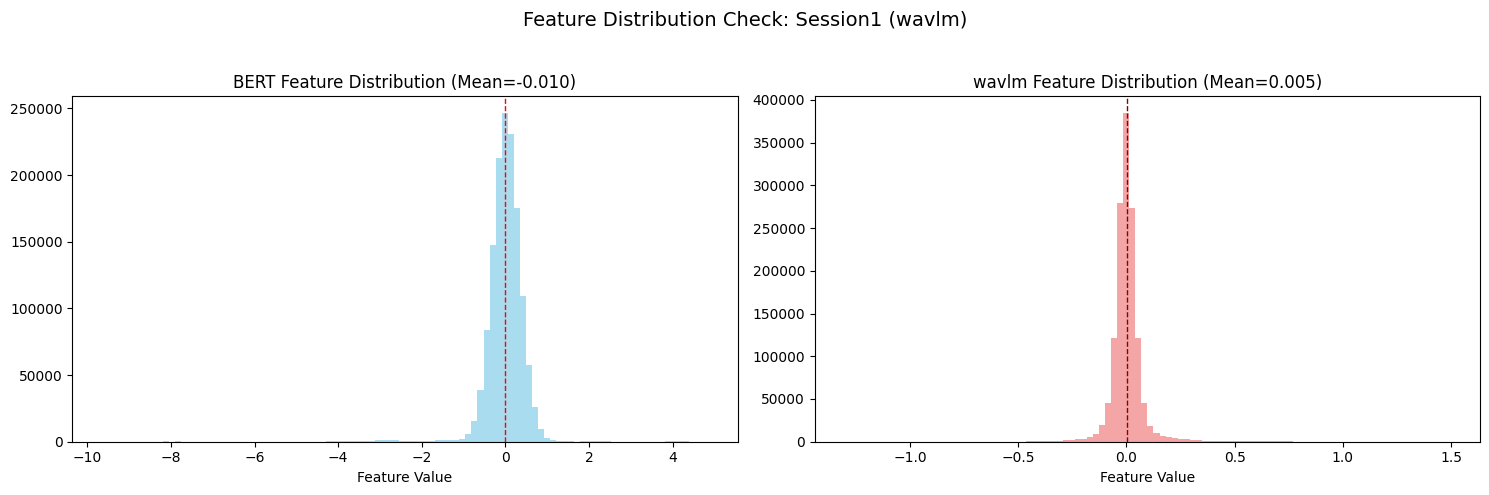


[检查 Session2]
🧩 当前检查特征类型: emotion2vec (e2v)
✅ 统计信息: F_t (Mean=-0.0104, Std=0.5302) | F_s (e2v) (Mean=0.0184, Std=1.0123)
✅ Session2 (e2v) 通过结构和内容检查。


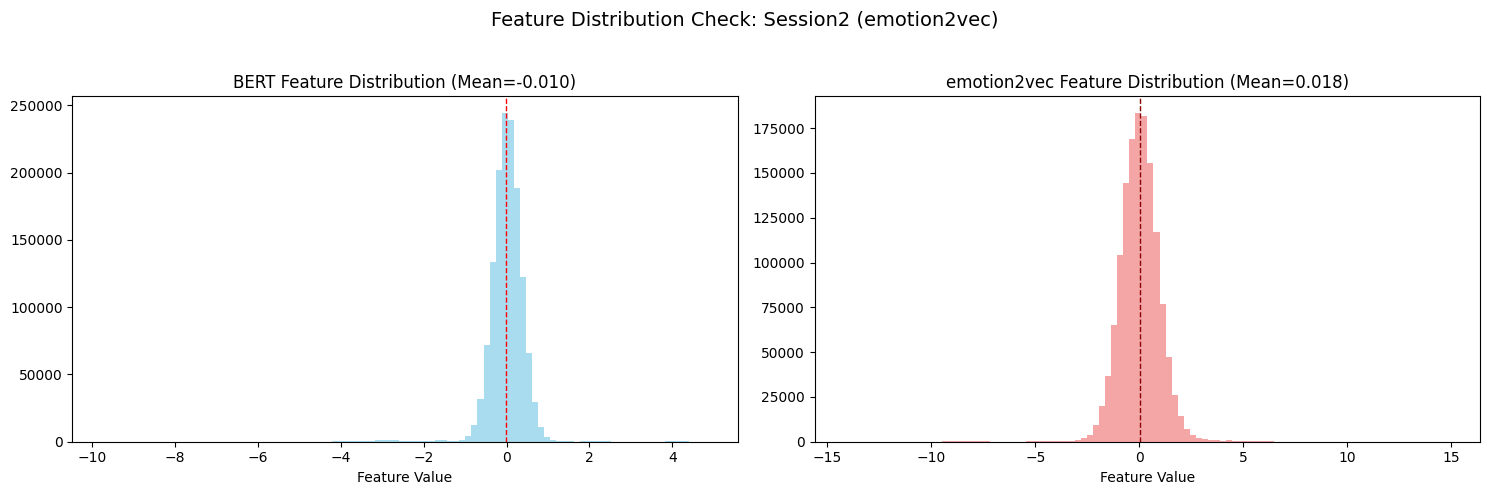

🧩 当前检查特征类型: wavlm (wavlm)
✅ 统计信息: F_t (Mean=-0.0104, Std=0.5302) | F_s (wavlm) (Mean=0.0048, Std=0.0801)
✅ Session2 (wavlm) 通过结构和内容检查。


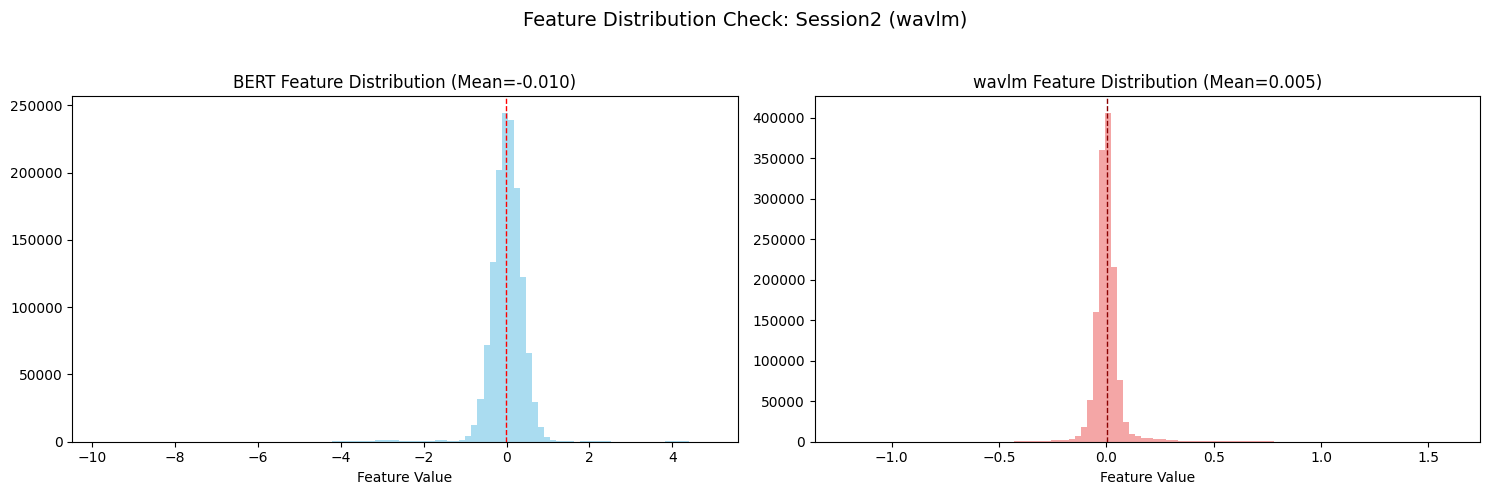


[检查 Session3]
🧩 当前检查特征类型: emotion2vec (e2v)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5316) | F_s (e2v) (Mean=0.0162, Std=0.9518)
✅ Session3 (e2v) 通过结构和内容检查。


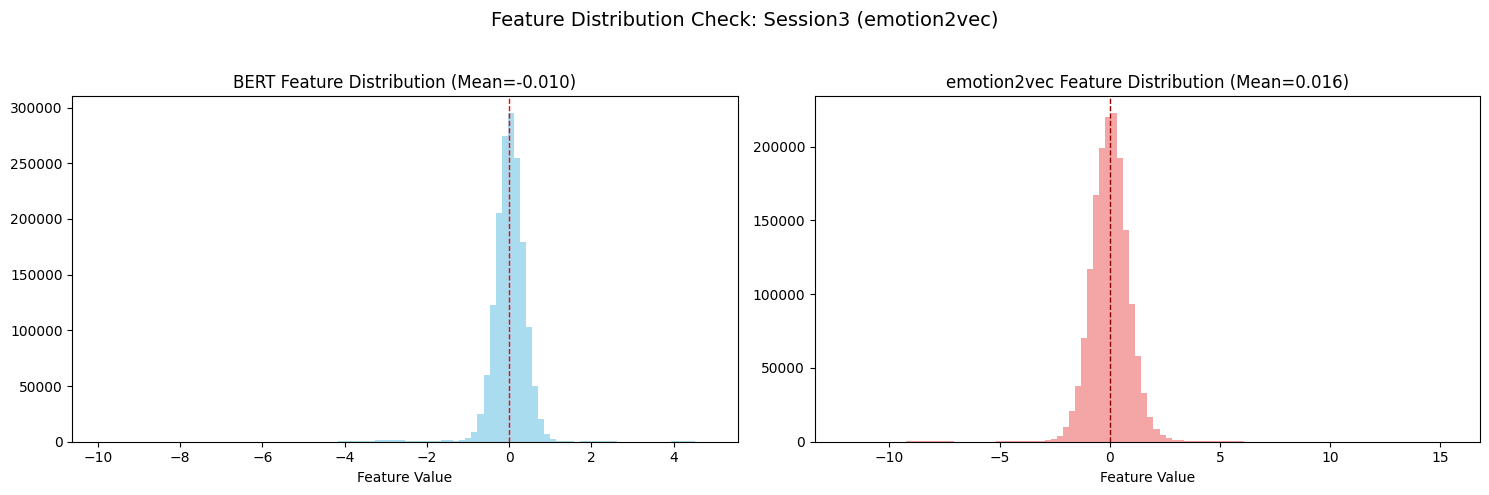

🧩 当前检查特征类型: wavlm (wavlm)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5316) | F_s (wavlm) (Mean=0.0045, Std=0.0866)
✅ Session3 (wavlm) 通过结构和内容检查。


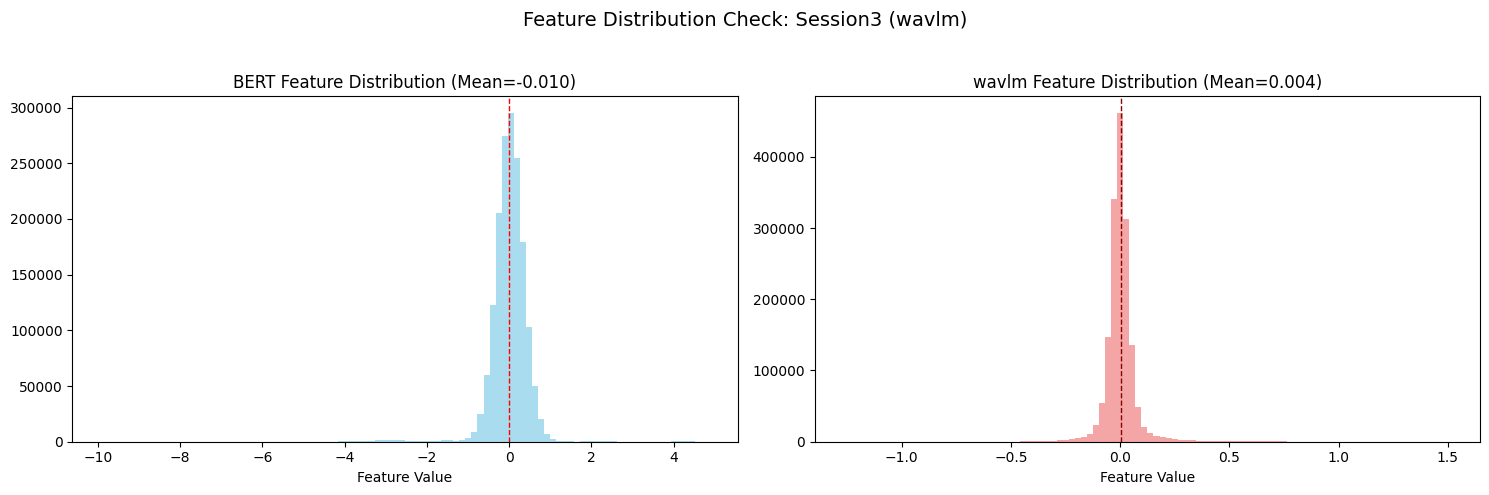


[检查 Session4]
🧩 当前检查特征类型: emotion2vec (e2v)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5327) | F_s (e2v) (Mean=0.0199, Std=1.0311)
✅ Session4 (e2v) 通过结构和内容检查。


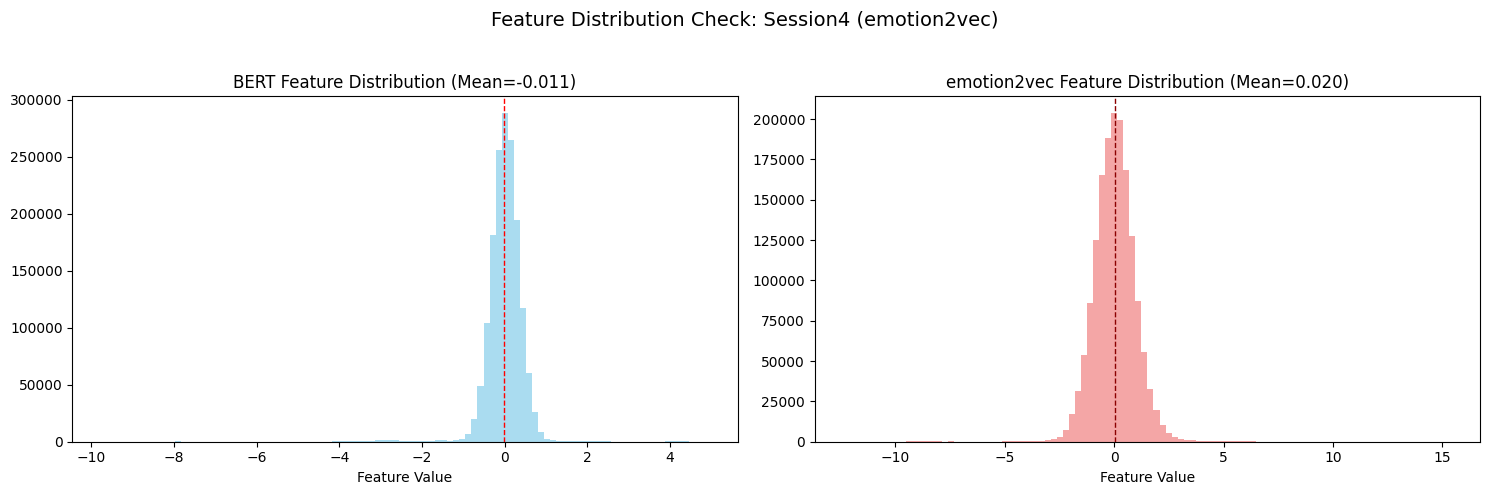

🧩 当前检查特征类型: wavlm (wavlm)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5327) | F_s (wavlm) (Mean=0.0047, Std=0.0808)
✅ Session4 (wavlm) 通过结构和内容检查。


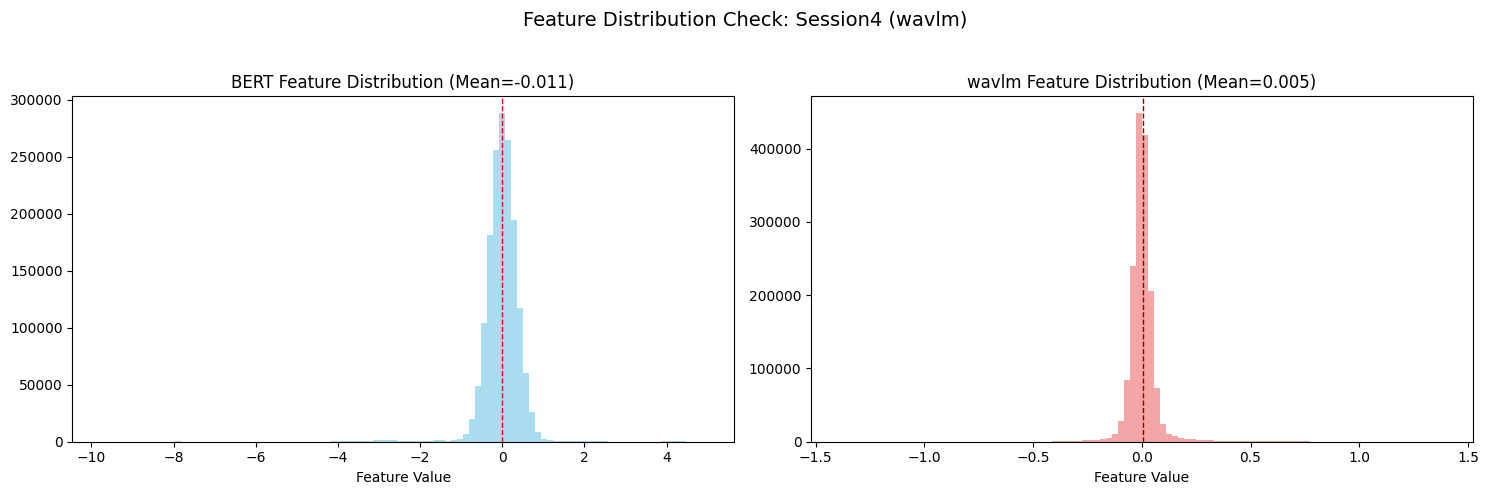


[检查 Session5]
🧩 当前检查特征类型: emotion2vec (e2v)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5322) | F_s (e2v) (Mean=0.0179, Std=0.9920)
✅ Session5 (e2v) 通过结构和内容检查。


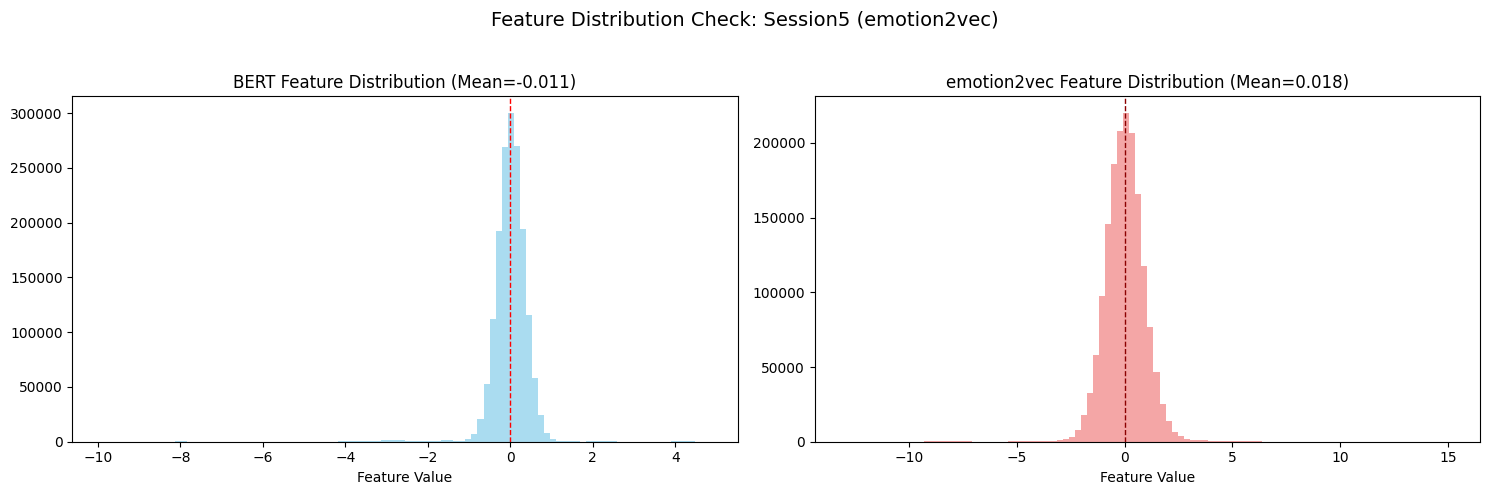

🧩 当前检查特征类型: wavlm (wavlm)
✅ 统计信息: F_t (Mean=-0.0105, Std=0.5322) | F_s (wavlm) (Mean=0.0046, Std=0.0831)
✅ Session5 (wavlm) 通过结构和内容检查。


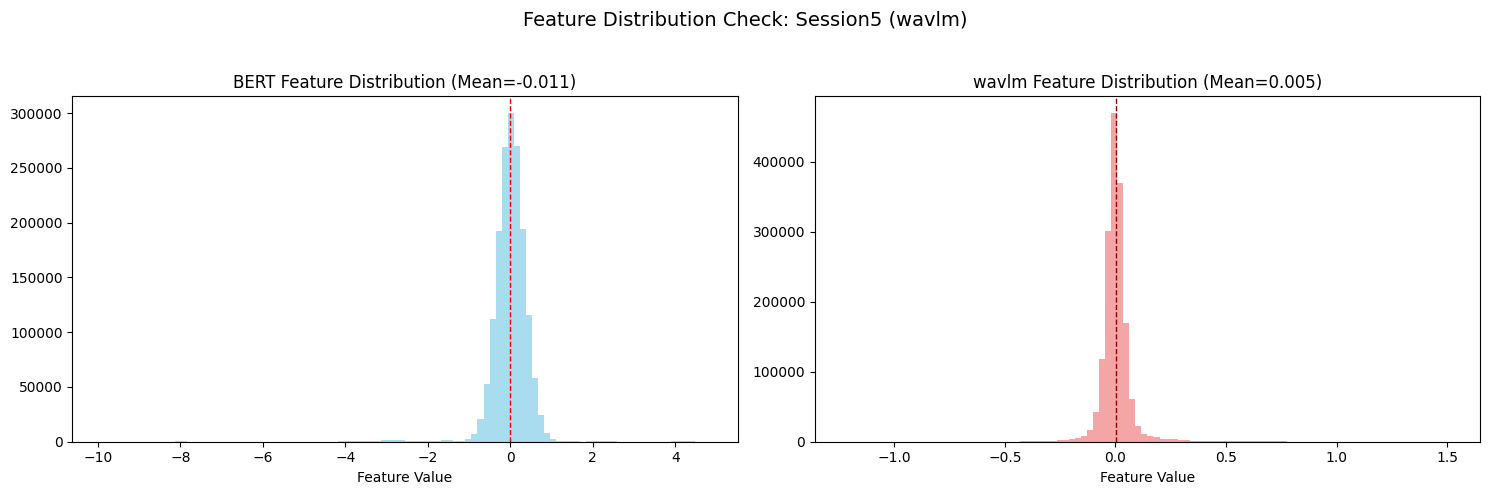


🧾 特征提取完整性检查报告 (Summary Report)


,Session,Tag,Utterances,F_t_Mean,F_t_Std,F_s_Mean,F_s_Std
0,Session1,emotion2vec,1807,-0.010481,0.531457,0.016753,0.972826
1,Session1,wavlm,1807,-0.010481,0.531457,0.004592,0.086757
2,Session2,emotion2vec,1802,-0.010413,0.530156,0.018371,1.012298
3,Session2,wavlm,1802,-0.010413,0.530156,0.004833,0.080113
4,Session3,emotion2vec,2134,-0.010460,0.531649,0.016224,0.951775
5,Session3,wavlm,2134,-0.010460,0.531649,0.004490,0.086561
6,Session4,emotion2vec,2096,-0.010515,0.532741,0.019922,1.031096
7,Session4,wavlm,2096,-0.010515,0.532741,0.004680,0.080807
8,Session5,emotion2vec,2159,-0.010514,0.532219,0.017869,0.992028
9,Session5,wavlm,2159,-0.010514,0.532219,0.004617,0.083104



📊 总回合数 = 9998
✅ 所有必需特征文件已通过检查，数据安全。


In [6]:
# ✅ Cell 3.5: 增强的特征完整性检查 (Feature Integrity Check, Final)


import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display # 用于在 Notebook 中显示 DataFrame

# --- 基础路径与参数 ---
# FEATURE_CACHE_DIR = './GM-EPC/data/features_cache' 
# FEATURE_CACHE_DIR = './GM-EPC/data/features_cache_e2v_base'
FEATURE_CACHE_DIR = './GM-EPC/data/features_cache_e2v_seed'
sessions = [f'Session{i}' for i in range(1, 6)]

EXPECTED_TEXT_DIM = 768
EXPECTED_SPEECH_DIM = 768

# 定义绘图函数 
def plot_feature_distributions(F_t, F_s, session_name, speech_tag):
    """绘制特征的均值和标准差直方图，以检查分布是否正常（通常应接近标准正态）。"""
    
    # 仅取非零特征进行可视化
    F_t_nonzero = F_t[np.any(F_t != 0, axis=1)]
    F_s_nonzero = F_s[np.any(F_s != 0, axis=1)]
    
    if len(F_t_nonzero) == 0 or len(F_s_nonzero) == 0:
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Feature Distribution Check: {session_name} ({speech_tag})", fontsize=14)

    # 文本特征分布
    axes[0].hist(F_t_nonzero.flatten(), bins=100, color='skyblue', alpha=0.7)
    axes[0].axvline(np.mean(F_t_nonzero), color='red', linestyle='dashed', linewidth=1)
    axes[0].set_title(f"BERT Feature Distribution (Mean={np.mean(F_t_nonzero):.3f})")
    axes[0].set_xlabel("Feature Value")

    # 语音特征分布
    axes[1].hist(F_s_nonzero.flatten(), bins=100, color='lightcoral', alpha=0.7)
    axes[1].axvline(np.mean(F_s_nonzero), color='darkred', linestyle='dashed', linewidth=1)
    axes[1].set_title(f"{speech_tag} Feature Distribution (Mean={np.mean(F_s_nonzero):.3f})")
    axes[1].set_xlabel("Feature Value")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


print("============================================================")
print("🔬 启动特征完整性检查 (Feature Integrity Check)")
print("============================================================")

summary_rows = [] 
total_utterances = 0
all_sessions_passed = True

# 🚨 检查 E2V 和 WavLM 两套特征
feature_tags = {'e2v': 'emotion2vec', 'wavlm': 'wavlm'}

for session_name in sessions:
    print(f"\n[检查 {session_name}]")
    
    ft_path = os.path.join(FEATURE_CACHE_DIR, f'{session_name}_F_t.npy')
    ids_path = os.path.join(FEATURE_CACHE_DIR, f'{session_name}_utt_ids.npy')
    
    # 确保通用特征文件存在
    if not os.path.exists(ft_path) or not os.path.exists(ids_path):
        print(f"❌ 错误：{session_name} 缺少通用特征文件 (F_t.npy 或 utt_ids.npy)。请先运行 Pass 1。")
        all_sessions_passed = False
        continue
        
    F_t = np.load(ft_path)
    utt_ids = np.load(ids_path, allow_pickle=True)
    N = len(utt_ids)
    
    if F_t.shape[0] != N:
         print(f"❌ 样本数量不一致: F_t={F_t.shape[0]}, utt_ids={N}")
         all_sessions_passed = False
         continue
         
    total_utterances += N
    
    # --- 循环检查两套语音特征 ---
    for tag, speech_tag_name in feature_tags.items():
        fs_path = os.path.join(FEATURE_CACHE_DIR, f'{session_name}_F_s_{tag}.npy')
        
        if not os.path.exists(fs_path):
            print(f"❌ 警告：{session_name} 缺少 {speech_tag_name} 语音特征文件 ({tag})。")
            all_sessions_passed = False
            continue
            
        print(f"🧩 当前检查特征类型: {speech_tag_name} ({tag})")

        # --- 加载语音特征 ---
        F_s = np.load(fs_path)
        
        # ============================================================
        # 【检查点 A】基本结构检查
        # ============================================================
        if F_s.shape[0] != N:
            print(f"❌ 样本数量不一致: F_s={F_s.shape[0]}, utt_ids={N}")
            all_sessions_passed = False
            continue
        if F_s.shape[-1] != EXPECTED_SPEECH_DIM:
            print(f"❌ 特征维度异常: F_s={F_s.shape[-1]}")
            all_sessions_passed = False
            continue

        # ============================================================
        # 【检查点 B/D】内容检查 (NaN, 零向量, 统计分布)
        # ============================================================
        if np.isnan(F_s).any():
            print("❌ 存在 NaN 值，请重新提取。")
            all_sessions_passed = False
            continue

        F_s_nonzero = F_s[np.any(F_s != 0, axis=1)]
        mean_s, std_s = (np.mean(F_s_nonzero), np.std(F_s_nonzero)) if len(F_s_nonzero) > 0 else (0, 0)
        
        # 你的原始检查逻辑（零向量检查）
        sample_idx = min(10, N - 1)
        if np.all(F_s[sample_idx] == 0):
            print(f"⚠️ {speech_tag_name} 样本 #{sample_idx} 为全零（可能是静音或缺失音频）。")

        if not (0.05 < std_s < 2.5) and N > 10:
            print(f"⚠️ {speech_tag_name} 整体方差异常: Std={std_s:.4f}")

        # 计算 F_t 的统计信息 (只计算一次，但在这里复用)
        F_t_nonzero = F_t[np.any(F_t != 0, axis=1)]
        mean_t, std_t = (np.mean(F_t_nonzero), np.std(F_t_nonzero)) if len(F_t_nonzero) > 0 else (0, 0)
        
        print(f"✅ 统计信息: F_t (Mean={mean_t:.4f}, Std={std_t:.4f}) | F_s ({tag}) (Mean={mean_s:.4f}, Std={std_s:.4f})")
        print(f"✅ {session_name} ({tag}) 通过结构和内容检查。")

        # 绘制分布图
        plot_feature_distributions(F_t, F_s, session_name, speech_tag_name)

        # 添加到汇总表
        summary_rows.append({
            'Session': session_name,
            'Tag': speech_tag_name,
            'Utterances': N,
            'F_t_Mean': mean_t,
            'F_t_Std': std_t,
            'F_s_Mean': mean_s,
            'F_s_Std': std_s
        })

# ============================================================
# 【汇总报告】
# ============================================================

summary_df = pd.DataFrame(summary_rows)
print("\n============================================================")
print("🧾 特征提取完整性检查报告 (Summary Report)")
print("============================================================")
if not summary_df.empty:
    display(summary_df.style.background_gradient(cmap='YlGnBu'))
else:
    print("❌ 未检测到任何有效特征文件。")

print(f"\n📊 总回合数 = {total_utterances}")
if all_sessions_passed:
    print("✅ 所有必需特征文件已通过检查，数据安全。")
else:
     print("❌ 存在文件缺失或数据结构问题，请检查警告和错误。")
print("============================================================")


In [6]:
# Cell 3.6: 压缩特征缓存文件夹 

import os

# FEATURE_CACHE_DIR = './GM-EPC/data/features_cache' 
FEATURE_CACHE_DIR = './GM-EPC/data/features_cache_e2v_base'

if os.path.exists(FEATURE_CACHE_DIR):
    OUTPUT_ZIP_FILE = 'features_cache_backup.zip'
    
    print(f"--- 🗜️ 正在压缩特征文件夹 '{FEATURE_CACHE_DIR}' ---")
    
    # 注意：压缩时，如果直接用 './GM-EPC/data/features_cache'，压缩包内部也会包含这些前缀。
    # 这在下载后管理是没问题的。
    !zip -r {OUTPUT_ZIP_FILE} {FEATURE_CACHE_DIR}
    
    print(f"✅ 压缩完成。文件已保存为: {OUTPUT_ZIP_FILE}")
    print("现在您可以直接下载这个 .zip 文件到本地了。")
    print("\n--- ❗ 重要：请记得将此文件夹保存为 Kaggle Output Dataset，供 Cell 4 使用 ❗ ---")
else:
    print(f"❌ 错误：未找到特征缓存目录 '{FEATURE_CACHE_DIR}'。请检查路径或运行 Cell 3。")

--- 🗜️ 正在压缩特征文件夹 './GM-EPC/data/features_cache_e2v_base' ---
  adding: GM-EPC/data/features_cache_e2v_base/ (stored 0%)
  adding: GM-EPC/data/features_cache_e2v_base/Session1_utt_ids.npy (deflated 96%)
  adding: GM-EPC/data/features_cache_e2v_base/Session1_F_t.npy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 9%)
✅ 压缩完成。文件已保存为: features_cache_backup.zip
现在您可以直接下载这个 .zip 文件到本地了。

--- ❗ 重要：请记得将此文件夹保存为 Kaggle Output Dataset，供 Cell 4 使用 ❗ ---


In [8]:
# === Debug Cell: Check Feature Cache Consistency ===

import os
import numpy as np

# FEATURE_CACHE_PATH = '/kaggle/input/features-cache/GM-EPC/data/features_cache'  # 修改为你Cell4里的路径
FEATURE_CACHE_PATH = '/kaggle/input/features-cache-e2v-base/GM-EPC/data/features_cache_e2v_base'

sessions = [f'Session{i}' for i in range(1, 6)]
TAGS = ['e2v', 'wavlm']  # 两种语音特征
missing = []

print(f"🔍 Checking feature files under: {FEATURE_CACHE_PATH}\n")

for sess in sessions:
    print(f"--- {sess} ---")
    
    # 检查文本特征
    ft_path = os.path.join(FEATURE_CACHE_PATH, f'{sess}_F_t.npy')
    ids_path = os.path.join(FEATURE_CACHE_PATH, f'{sess}_utt_ids.npy')
    
    if not os.path.exists(ft_path):
        print(f"❌ Missing: {ft_path}")
        missing.append(ft_path)
    else:
        arr = np.load(ft_path)
        print(f"✅ Found F_t.npy | shape={arr.shape}")
    
    if not os.path.exists(ids_path):
        print(f"❌ Missing: {ids_path}")
        missing.append(ids_path)
    else:
        ids = np.load(ids_path, allow_pickle=True)
        print(f"✅ Found utt_ids.npy | len={len(ids)}")
    
    # 检查语音特征两种命名
    for tag in TAGS:
        fs_path = os.path.join(FEATURE_CACHE_PATH, f'{sess}_F_s_{tag}.npy')
        if os.path.exists(fs_path):
            arr = np.load(fs_path)
            print(f"✅ Found F_s_{tag}.npy | shape={arr.shape}")
        else:
            print(f"⚠️ Not found: F_s_{tag}.npy")
    print("")

print("===============================================")
if missing:
    print(f"❌ Missing {len(missing)} files in total. These must exist for training.")
else:
    print("✅ All essential files are present. You can safely train.")


🔍 Checking feature files under: /kaggle/input/features-cache-e2v-base/GM-EPC/data/features_cache_e2v_base

--- Session1 ---
✅ Found F_t.npy | shape=(1807, 768)
✅ Found utt_ids.npy | len=1807
✅ Found F_s_e2v.npy | shape=(1807, 768)
✅ Found F_s_wavlm.npy | shape=(1807, 768)

--- Session2 ---
✅ Found F_t.npy | shape=(1802, 768)
✅ Found utt_ids.npy | len=1802
✅ Found F_s_e2v.npy | shape=(1802, 768)
✅ Found F_s_wavlm.npy | shape=(1802, 768)

--- Session3 ---
✅ Found F_t.npy | shape=(2134, 768)
✅ Found utt_ids.npy | len=2134
✅ Found F_s_e2v.npy | shape=(2134, 768)
✅ Found F_s_wavlm.npy | shape=(2134, 768)

--- Session4 ---
✅ Found F_t.npy | shape=(2096, 768)
✅ Found utt_ids.npy | len=2096
✅ Found F_s_e2v.npy | shape=(2096, 768)
✅ Found F_s_wavlm.npy | shape=(2096, 768)

--- Session5 ---
✅ Found F_t.npy | shape=(2159, 768)
✅ Found utt_ids.npy | len=2159
✅ Found F_s_e2v.npy | shape=(2159, 768)
✅ Found F_s_wavlm.npy | shape=(2159, 768)

✅ All essential files are present. You can safely train.


In [4]:
# ============================================================
# 📦 Cell 4: 实验配置与环境设置（新版兼容 GM-EPC + WavLM）
# ============================================================

import os
import torch
import pandas as pd
from trainer import run_experiment
from dataset import IEMOCAPDataset 

# --- 1. 定义运行环境路径 ---

#  1. 原始数据路径 (用于获取 ID, Label, 顺序) 
ORIGINAL_DATA_ROOT = '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release' 

#  2. 缓存特征路径 (用于加载 F_t.npy, F_s.npy) 
#FEATURE_CACHE_PATH = '/kaggle/input/features-cache/GM-EPC/data/features_cache' 
FEATURE_CACHE_PATH = '/kaggle/input/features-cache-e2v-base/GM-EPC/data/features_cache_e2v_base'
#FEATURE_CACHE_PATH = '/kaggle/input/features-cache-seed/GM-EPC/data/features_cache_e2v_seed'

# --- 2. 实验超参数配置 ---
CONFIG = {
    # 可选模型：
    # "GM-EPC"               → Gated Fusion (E2V)
    # "Text-Only"            → 文本单模态基线
    # "Speech-Only"          → Emotion2Vec 单模态基线
    # "Dynamic-WavLM"        → WavLM 动态融合模型
    # "Speech-Only (WavLM)"  → WavLM 单模态基线
    'model_name': 'GM-EPC',  
    'original_data_root': ORIGINAL_DATA_ROOT, 
    'feature_cache_path': FEATURE_CACHE_PATH,
    'history_len': 3,
    'num_classes': 4,
    
    # 训练超参数
    'batch_size': 32,
    'epochs': 50,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'hidden_size': 256, # GRU 隐藏层大小
    'patience': 10,     # 早停耐心值
    'test_samples': 100, # 仅占位参数，用于本地调试
    
    # ✅ 新版实验模型列表（与 trainer.py 完全对应）
    'model_list': [
        "GM-EPC",
        "Text-Only",
        "Speech-Only",
        "Dynamic-WavLM",
        "Speech-Only (WavLM)"
    ]
}

# --- 3. 验证环境 ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Model Configuration Loaded:\n{CONFIG}")


If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
If you want use mossformer, lease install rotary_embedding_torch by: 
 pip install -U rotary_embedding_torch
Using device: cuda
Model Configuration Loaded:
{'model_name': 'GM-EPC', 'original_data_root': '/kaggle/input/iemocapfullrelease/IEMOCAP_full_release', 'feature_cache_path': '/kaggle/input/features-cache-e2v-base/GM-EPC/data/features_cache_e2v_base', 'history_len': 3, 'num_classes': 4, 'batch_size': 32, 'epochs': 50, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'hidden_size': 256, 'patience': 10, 'test_samples': 100, 'model_list': ['GM-EPC', 'Text-Only', 'Speech-Only', 'Dynamic-WavLM', 'Speech-Only (WavLM)']}


Available keys: ['gate_means', 'gate_stds']
✅ Data loaded. Shape (means): (5528,), (stds): (5528,)
Gate Mean: 0.509 ± 0.006
Gate Std : 0.128 ± 0.017


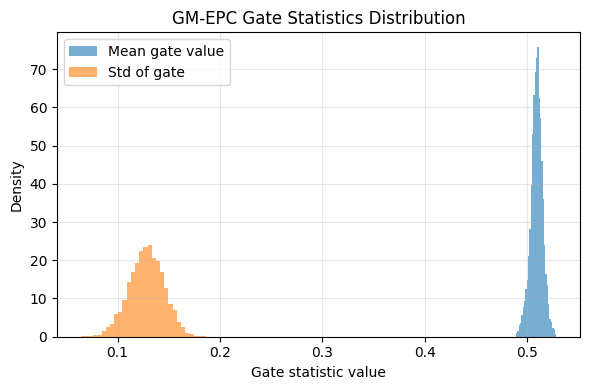

✅ Saved to figs/Figure_GateStatsDistribution.png


In [9]:
# ============================================================
# ⚙️ Cell 6.0: Gate Mechanism Statistical Distribution
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("figs", exist_ok=True)

# === 1️⃣ 载入门控统计数据 ===
data = np.load("./gate_stats_GatedMultimodalEPC.npz")
print("Available keys:", data.files)

gate_means = data["gate_means"]
gate_stds  = data["gate_stds"]  # 如果是 gate_vars，就改成 data["gate_vars"]

print(f"✅ Data loaded. Shape (means): {gate_means.shape}, (stds): {gate_stds.shape}")

# === 2️⃣ 输出统计指标 ===
print(f"Gate Mean: {gate_means.mean():.3f} ± {gate_means.std():.3f}")
print(f"Gate Std : {gate_stds.mean():.3f} ± {gate_stds.std():.3f}")

# === 3️⃣ 绘制分布直方图 ===
plt.figure(figsize=(6,4))
plt.hist(gate_means, bins=30, alpha=0.6, label='Mean gate value', density=True)
plt.hist(gate_stds, bins=30, alpha=0.6, label='Std of gate', density=True)
plt.xlabel("Gate statistic value")
plt.ylabel("Density")
plt.legend()
plt.title("GM-EPC Gate Statistics Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/Figure_GateStatsDistribution.png", dpi=600, bbox_inches="tight")
plt.show()

print("✅ Saved to figs/Figure_GateStatsDistribution.png")


In [6]:
# ============================================================
# 📊 Cell 6.1: Main Results Comparison Table (Final Clean Version)
# ============================================================

import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

MODEL_NAME_MAP = {
    "GM-EPC": "Gated Fusion (E2V)",
    "Dynamic-WavLM": "Gated Fusion (WavLM)",
    "Static-Fusion": "Static Fusion (E2V)",
    "Speech-Only": "Speech-Only (E2V)",
    "Text-Only": "Text-Only"
}

# 创建保存路径
os.makedirs("tables", exist_ok=True)

# 将旧模型名映射为新命名（兼容旧版本 DataFrame）
if "Model" in final_summary_df.columns:
    final_summary_df["Model"] = final_summary_df["Model"].map(MODEL_NAME_MAP).fillna(final_summary_df["Model"])

# 聚合三大性能指标 + 训练时间
metric_cols = [c for c in ["Test_Macro_F1", "Test_UAR", "Test_WA", "Train_Time_s"] if c in final_summary_df.columns]
summary_stats = (
    final_summary_df.groupby("Model")[metric_cols]
    .agg(["mean", "std"])
    .round(2)
)

# 扁平化列名
summary_stats.columns = ["_".join(col).strip() for col in summary_stats.columns.values]
summary_stats.reset_index(inplace=True)

# 删除无关列
summary_stats = summary_stats.drop(
    columns=["Train_Time_s_std", "Params (M)_mean", "Params (M)_std"],
    errors="ignore"
)

# --- 🎯 Paired t-test: Gated Fusion (E2V) vs Static Fusion (E2V) ---
try:
    model_gated = all_model_results.get("Gated Fusion (E2V)", {}).get("results_df", pd.DataFrame()).get("Test_Macro_F1", None)
    model_static = all_model_results.get("Static Fusion (E2V)", {}).get("results_df", pd.DataFrame()).get("Test_Macro_F1", None)

    if model_gated is not None and model_static is not None:
        t_stat, p_val = ttest_rel(model_gated.values, model_static.values)
        print(f"Paired t-test (Gated Fusion (E2V) vs Static Fusion (E2V)): t={t_stat:.3f}, p={p_val:.4f}")
    else:
        print("⚠️ Missing data for t-test comparison.")
except Exception as e:
    print("⚠️ Could not compute t-test:", e)

# ✅ 保留两位小数
float_cols = [c for c in summary_stats.columns if np.issubdtype(summary_stats[c].dtype, np.number)]
summary_stats[float_cols] = summary_stats[float_cols].apply(lambda col: col.round(2))

# ✅ 导出结果表
out_path = "tables/Table1_MainResults.csv"
summary_stats.to_csv(out_path, index=False, float_format="%.2f")

display(summary_stats)
print(f"✅ [Table 1] Clean Results saved to {out_path}")


⚠️ Missing data for t-test comparison.


,Model,Test_Macro_F1_mean,Test_Macro_F1_std,Test_UAR_mean,Test_UAR_std,Test_WA_mean,Test_WA_std,Train_Time_s_mean
0,Gated Fusion (E2V),0.807215,0.02,0.818476,0.02,0.805007,0.02,24.265068
1,Gated Fusion (WavLM),0.806687,0.02,0.814768,0.02,0.804428,0.02,22.204844
2,Speech-Only (E2V),0.734131,0.02,0.746846,0.02,0.729964,0.02,25.373149
3,Speech-Only (WavLM),0.715824,0.01,0.725547,0.01,0.712248,0.01,38.709394
4,Text-Only,0.721906,0.04,0.741291,0.04,0.722371,0.04,23.372448


✅ [Table 1] Clean Results saved to tables/Table1_MainResults.csv


/tmp/ipykernel_38/2648631988.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
/tmp/ipykernel_38/2648631988.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(models))


Text-Only              | Per-class F1: [0.769 0.768 0.71  0.648]
Speech-Only (E2V)      | Per-class F1: [0.749 0.792 0.767 0.639]
Gated Fusion (E2V)     | Per-class F1: [0.836 0.862 0.815 0.726]
Speech-Only (WavLM)    | Per-class F1: [0.696 0.779 0.729 0.67 ]
Gated Fusion (WavLM)   | Per-class F1: [0.846 0.862 0.801 0.722]


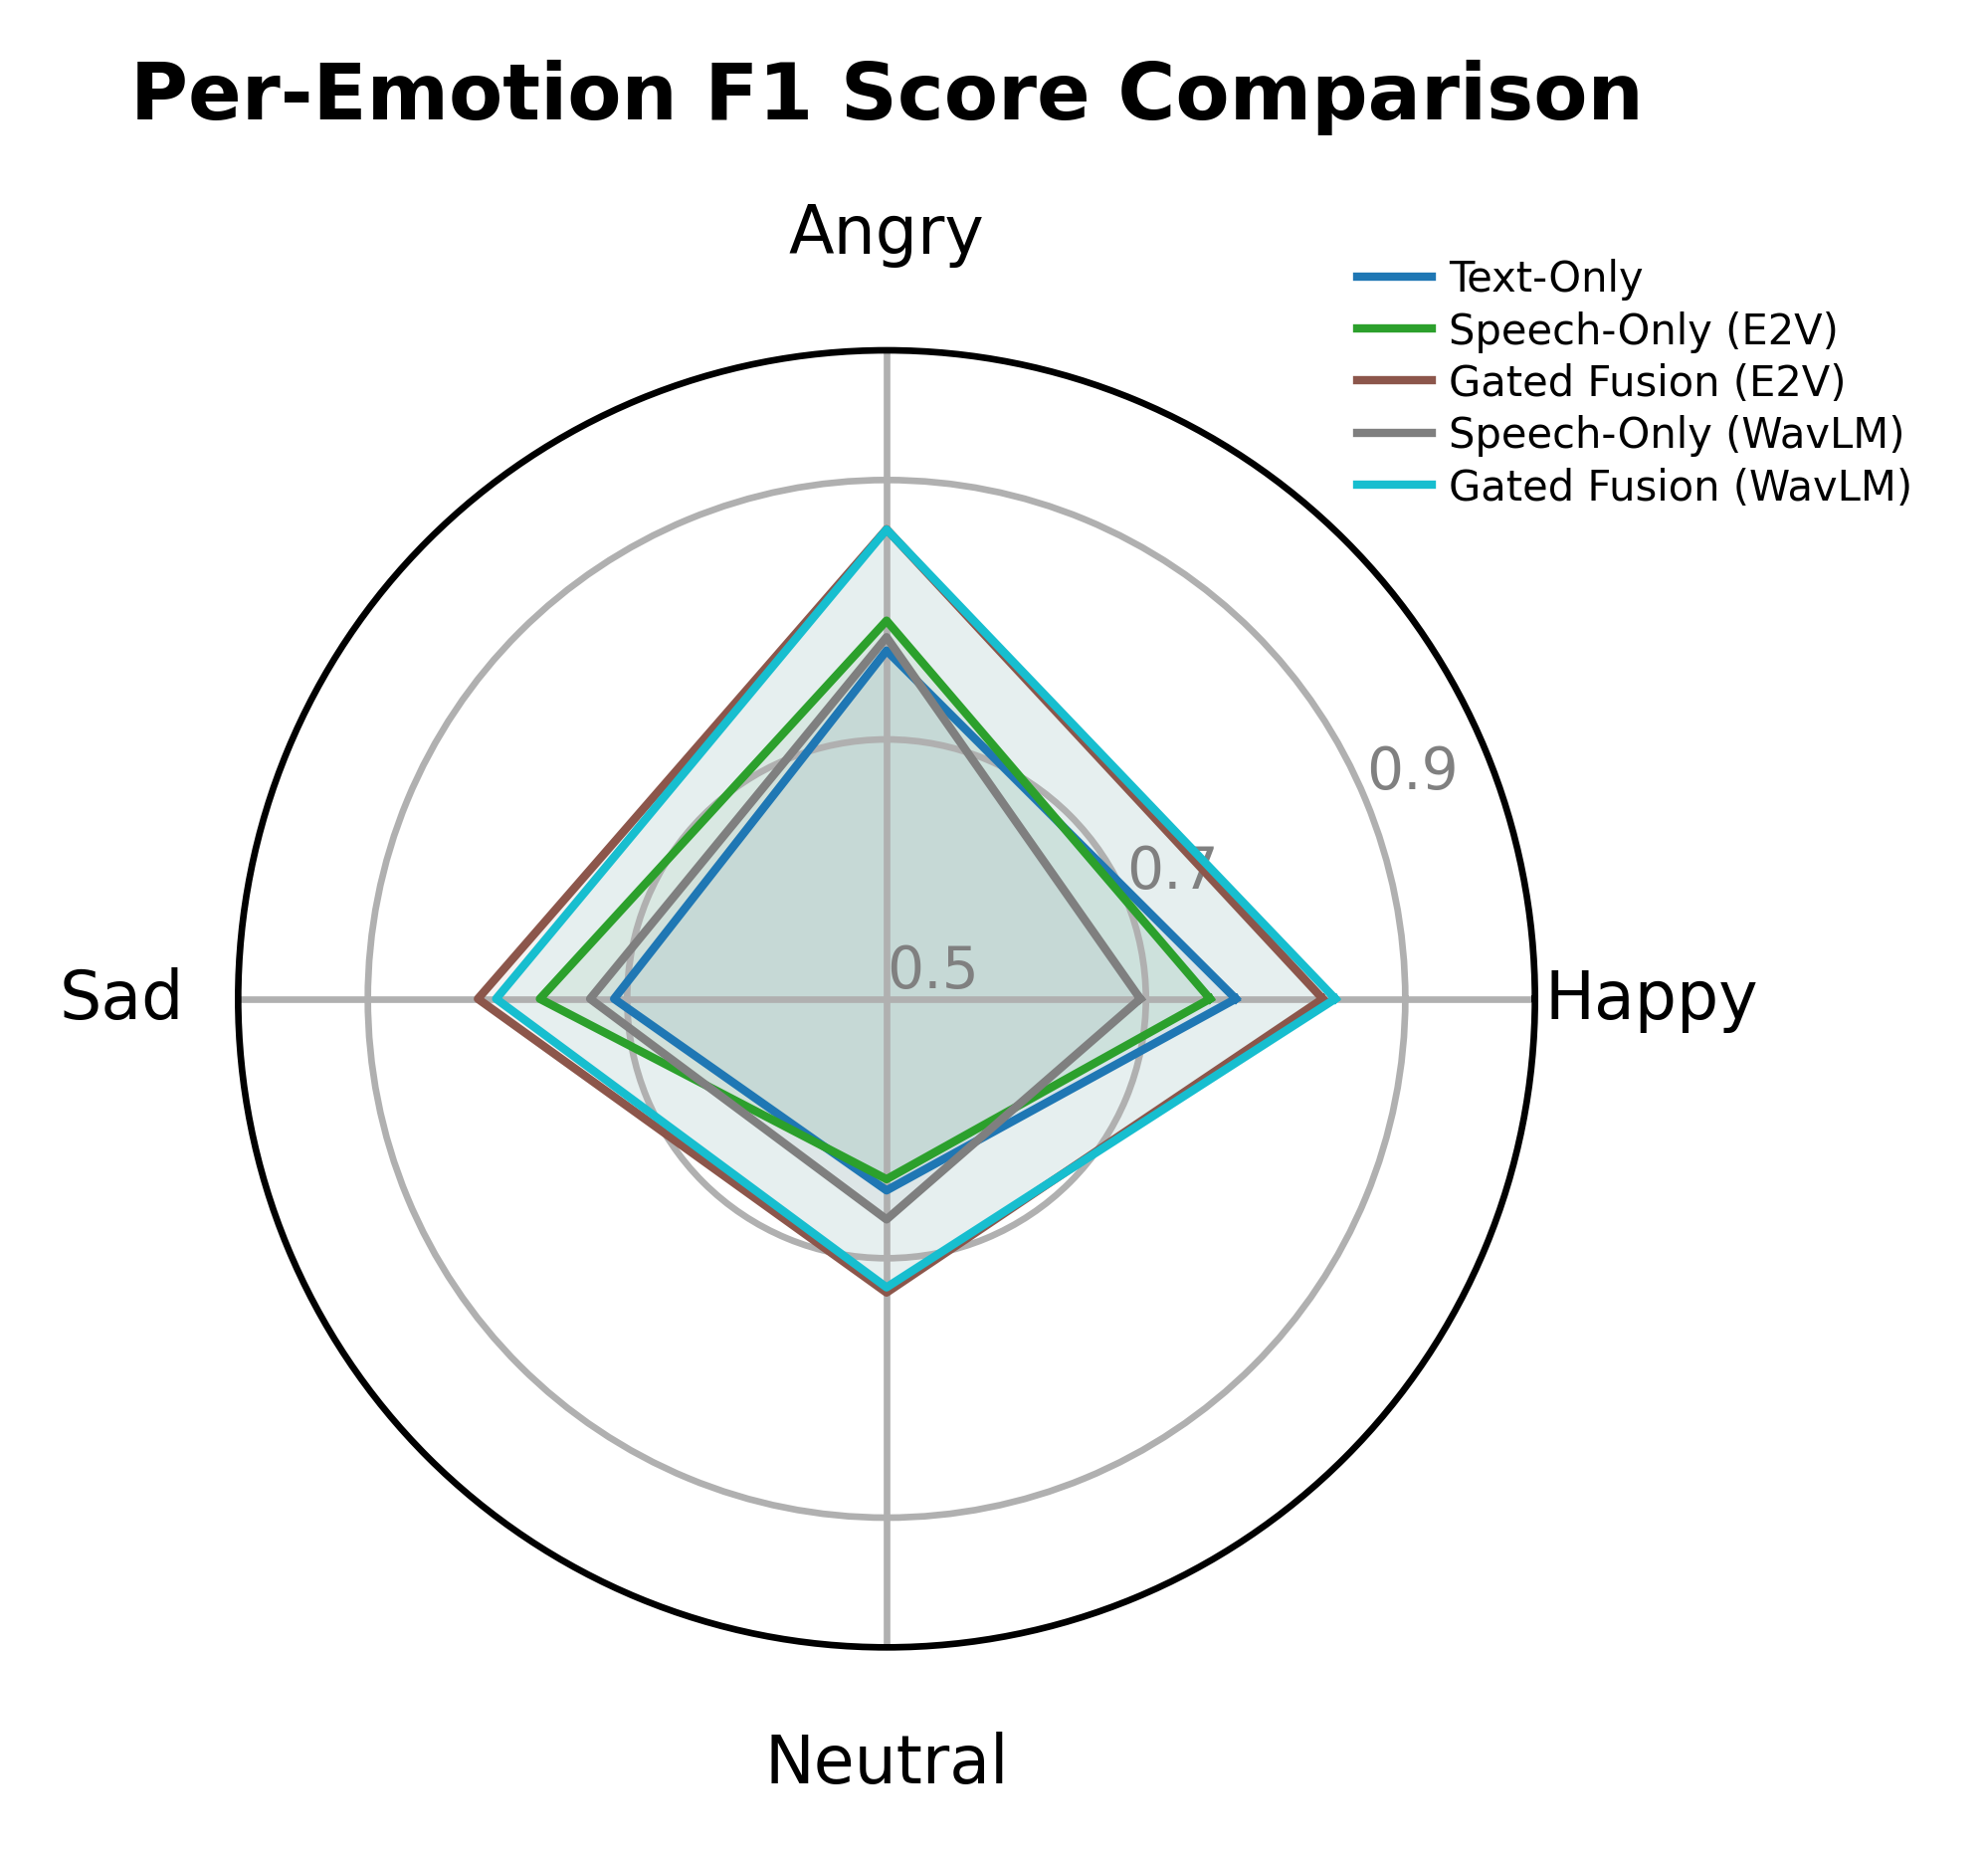

✅ Saved high-resolution figure to: figs/Per-Emotion F1 Score Comparison.png


In [10]:
# ============================================================
# 📈 Cell 6.2 : Figure 2 — Per-Emotion F₁ Radar Plot (Final Verified Version)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import f1_score
from IPython.display import set_matplotlib_formats

# 高清显示设置
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8


def plot_radar_per_class_f1(all_model_results):
    os.makedirs("figs", exist_ok=True)

    # === 情绪类别定义（保持与 dataset.py 一致） ===
    emotions = ["Happy", "Angry", "Sad", "Neutral"]
    emotion_ids = [0, 1, 2, 3]    # ✅ 保留，确保顺序一致

    # === 模型列表（论文展示顺序，已互换颜色对应的模型位置） ===
    models = [
        "Text-Only",
        "Speech-Only (E2V)",
        # --- 互换的部分 ---
        "Gated Fusion (E2V)",      # 现索引 2，获取原 Speech-Only (WavLM) 的颜色
        "Speech-Only (WavLM)",     # 现索引 3，获取原 Gated Fusion (E2V) 的颜色
        # -----------------
        "Gated Fusion (WavLM)"
    ]

    # === 从实验结果中计算每类 F1 ===
    data = {}
    for m in models:
        if m not in all_model_results:
            print(f"⚠️ Missing data for model: {m}")
            continue

        # 注意：这里从 all_model_results 中取数据是基于模型名称 m，不受列表顺序影响。
        preds = np.array(all_model_results[m]["preds"])
        labels = np.array(all_model_results[m]["labels"])

        if preds.size == 0 or labels.size == 0:
            print(f"⚠️ Empty preds/labels for {m}")
            continue

        f1s = f1_score(labels, preds, average=None, labels=emotion_ids)
        data[m] = f1s
        print(f"{m:22s} | Per-class F1: {np.round(f1s, 3)}")

    if not data:
        raise ValueError("❌ No valid model data found for radar plot.")

    # === 雷达图角度计算 ===
    labels = np.array(emotions)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # === 绘图部分（保持你原来的风格） ===
    plt.figure(figsize=(3.3, 3.3))
    cmap = plt.cm.get_cmap("tab10", len(models))

    # 绘图循环：i 决定颜色，m 决定数据
    for i, m in enumerate(models):
        if m not in data:
            continue
        vals = data[m]
        stats = np.concatenate((vals, [vals[0]]))
        plt.polar(angles, stats, linewidth=1.0, color=cmap(i), label=m)
        plt.fill(angles, stats, color=cmap(i), alpha=0.07)

    # ✅ 刻度区间：按你实验数据范围设置
    plt.xticks(angles[:-1], labels, fontsize=8)
    plt.yticks([0.5, 0.7, 0.9], ["0.5", "0.7", "0.9"], color="gray", size=7)
    plt.ylim(0.5, 1.0)
    plt.style.use('seaborn-v0_8-muted')


    plt.title("Per-Emotion F1 Score Comparison", size=9.5, weight="bold", pad=10)

    plt.legend(
        loc='upper right',
        bbox_to_anchor=(1.32, 1.10),
        fontsize=5.0,
        frameon=False,
        labelspacing=0.25,
        handlelength=1.8,
        handletextpad=0.4
    )

    plt.tight_layout(pad=0.3)

    # ✅ 保存高清图像
    save_path = "figs/Per-Emotion F1 Score Comparison.png"
    plt.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.02)
    plt.show()

    print(f"✅ Saved high-resolution figure to: {save_path}")


# === 调用函数 ===
plot_radar_per_class_f1(all_model_results) 

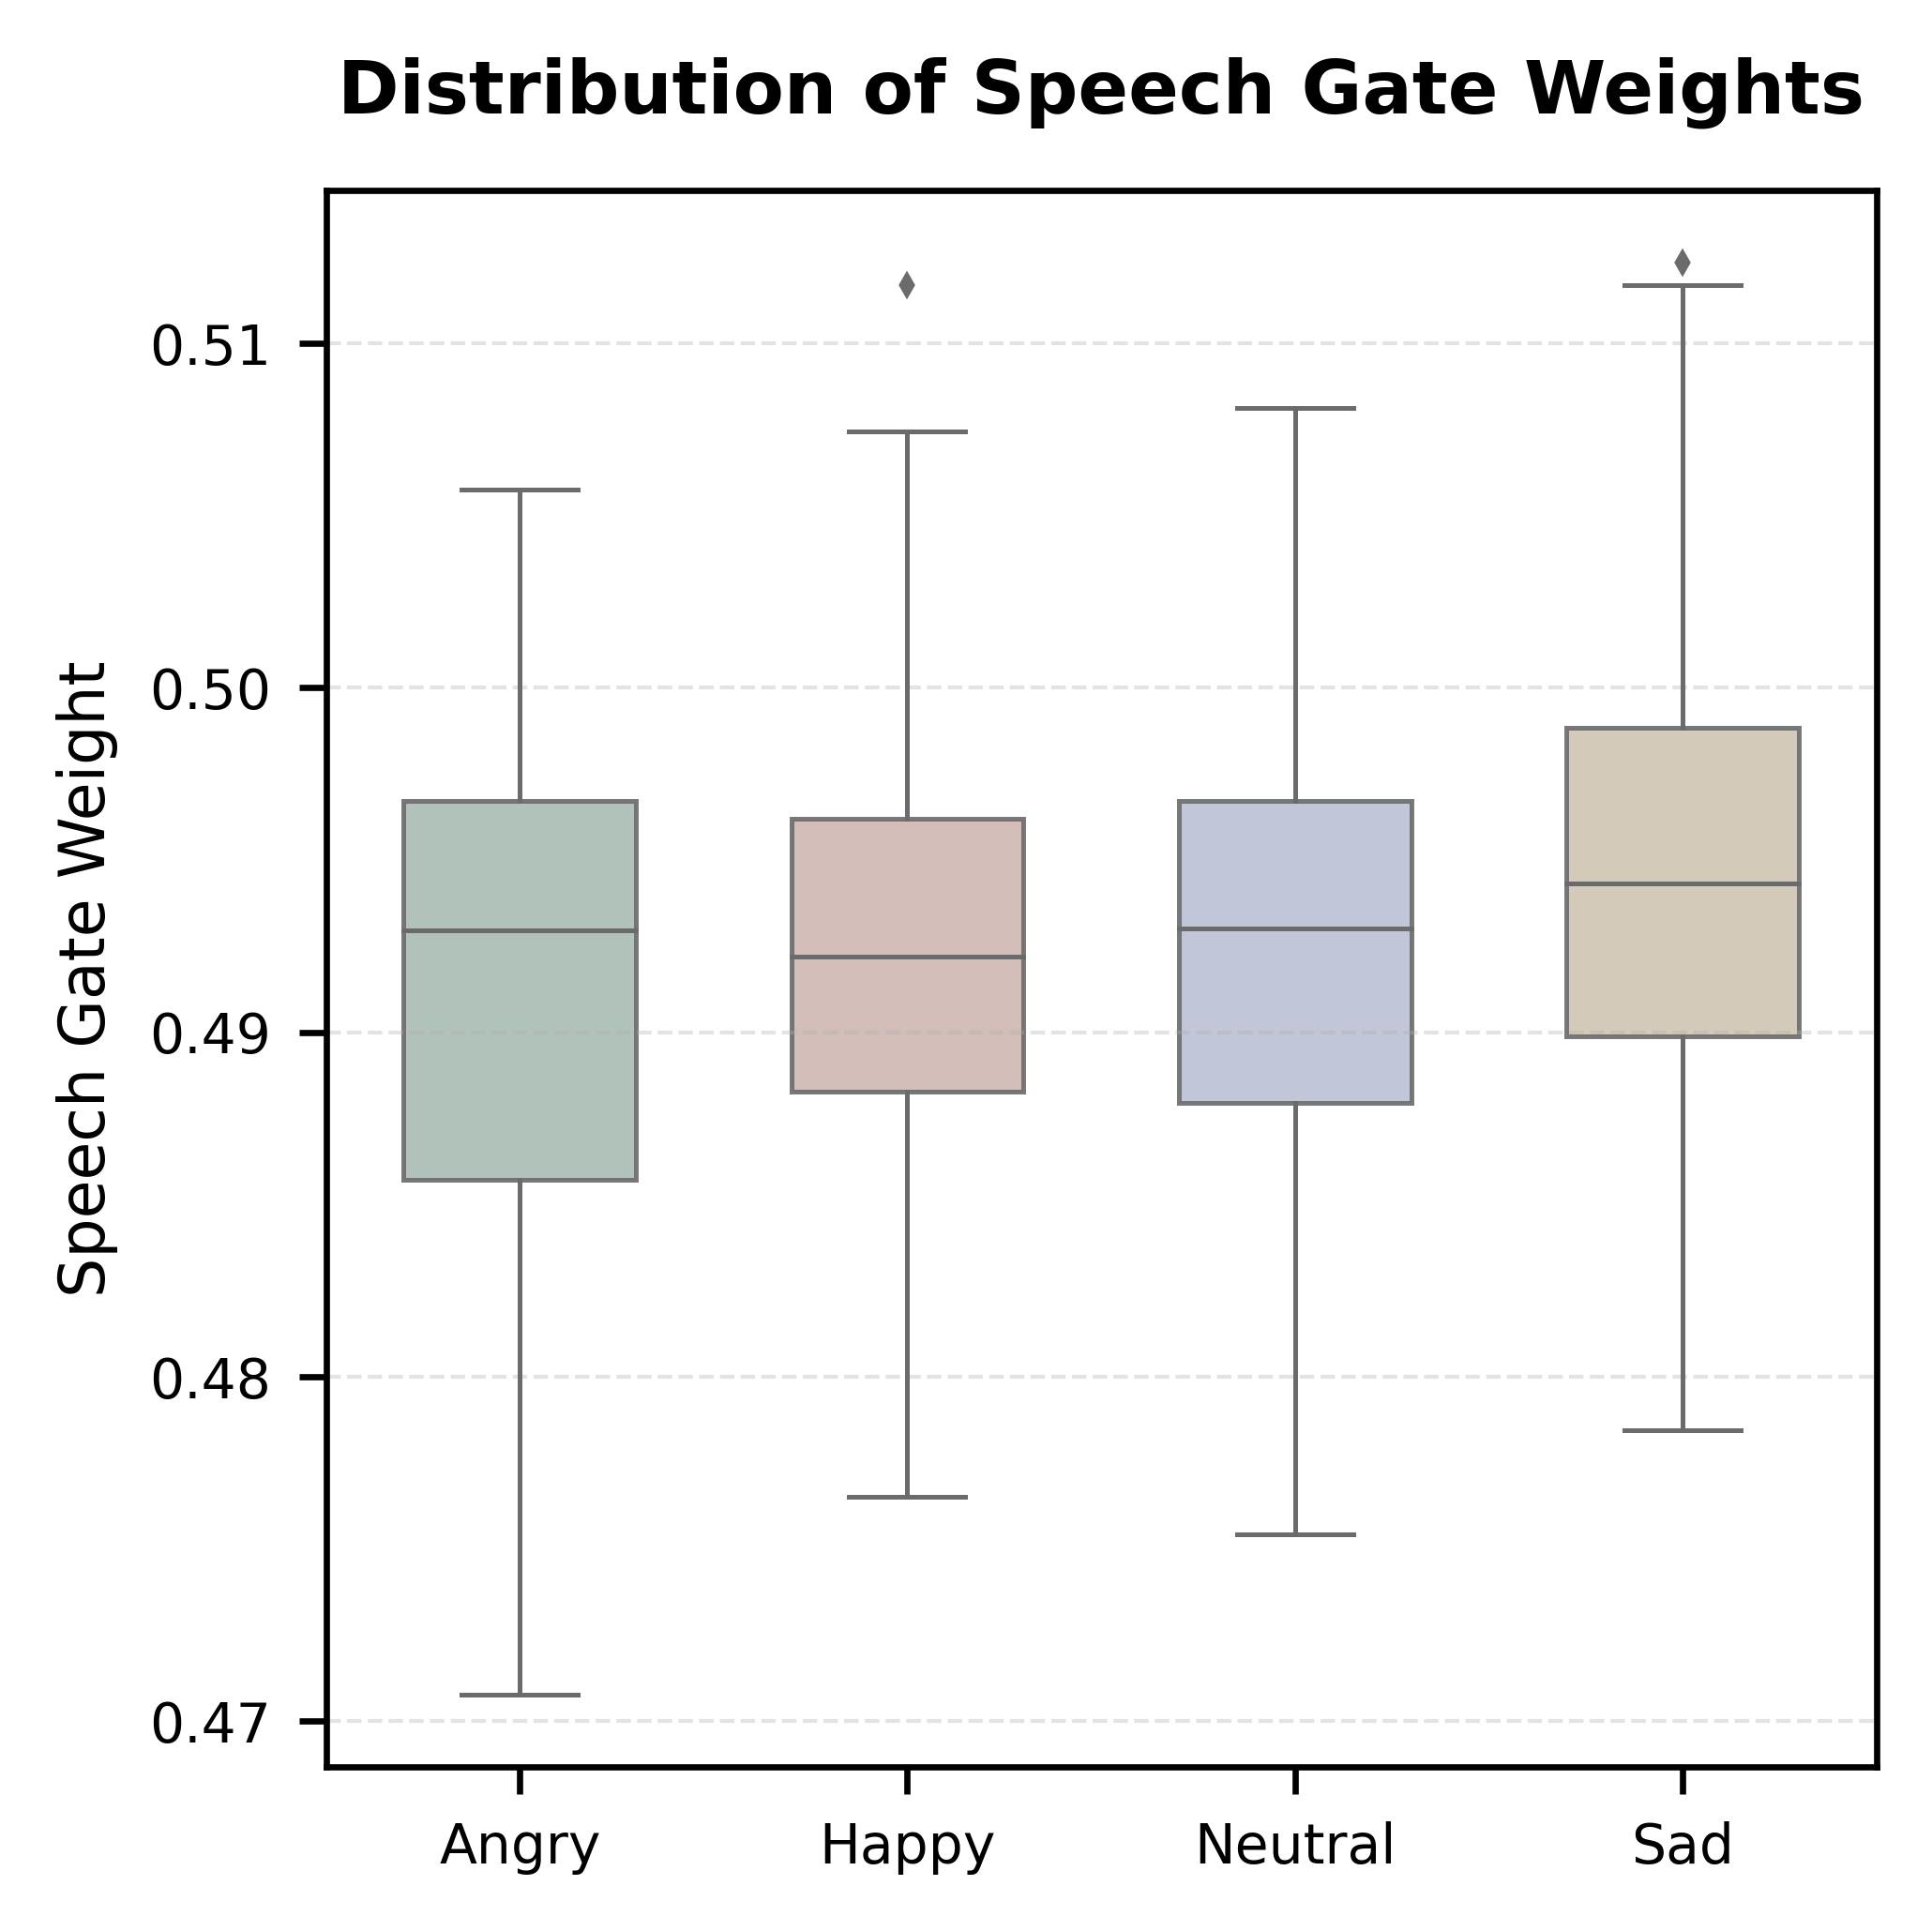

✅ Saved high-resolution figure to: figs/Figure3_GateWeight_Boxplot_PaperEdition.png

Per-Emotion Speech Gate Statistics (Median ± Std):
Angry    → median = 0.493, std = 0.007
Happy    → median = 0.492, std = 0.005
Neutral  → median = 0.493, std = 0.006
Sad      → median = 0.494, std = 0.006


In [10]:
# ============================================================
# 📦 Cell 6.3 : Figure 3 (Paper Edition) — Distribution of Speech Gate Weights (E2V Model)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib_inline.backend_inline import set_matplotlib_formats

# --- 高清设置 ---
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8


def plot_gate_boxplot(gate_weights, labels):
    os.makedirs("figs", exist_ok=True)

    # Step 1️: 提取 gate mean 值并计算语音权重 (1 - α)
    gate_mean_values = []
    for g in gate_weights:
        if isinstance(g, dict) and "mean" in g:
            gate_mean_values.extend(np.ravel(g["mean"]))
        else:
            gate_mean_values.append(float(g))
    speech_weights = 1 - np.array(gate_mean_values)

    # Step 2️: 数字标签 → 情绪名称映射
    id2emo = {0: "Happy", 1: "Angry", 2: "Sad", 3: "Neutral"}
    label_names = [id2emo.get(int(l), str(l)) for l in labels[:len(speech_weights)]]

    # 固定情绪显示顺序
    emotions = ["Angry", "Happy", "Neutral", "Sad"]

    # Step 3️: 构建 DataFrame
    df_gate = pd.DataFrame({
        "Emotion": label_names,
        "SpeechWeight": speech_weights
    })

    # Step 4️: 
    morandi_paper_palette = [
        (0.65, 0.75, 0.70),  # soft sage green
        (0.82, 0.70, 0.68),  # muted rose
        (0.72, 0.74, 0.85),  # soft periwinkle
        (0.83, 0.78, 0.68),  # beige sand
    ]

    # Step 5️: 绘图
    plt.figure(figsize=(3.3, 3.3))
    sns.boxplot(
        x="Emotion",
        y="SpeechWeight",
        data=df_gate,
        order=emotions,
        palette=morandi_paper_palette,
        linewidth=0.6,
        fliersize=1.2,
        width=0.6,
        boxprops=dict(alpha=0.9)
    )

    plt.title("Distribution of Speech Gate Weights", fontsize=9.5, weight="bold", pad=10)
    plt.ylabel("Speech Gate Weight", fontsize=8)
    plt.xlabel(None)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

    #  学术风格虚线灰网格
    plt.grid(axis='y', linestyle='--', alpha=0.35, linewidth=0.5)
    plt.grid(axis='x', linestyle='')

    plt.tight_layout(pad=0.3)

    save_path = "figs/Figure3_GateWeight_Boxplot_PaperEdition.png"
    plt.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.02)
    plt.show()

    print(f" Saved high-resolution figure to: {save_path}")

    # Step 6️: 输出每个情绪的中位数 (median) 与标准差
    print("\nPer-Emotion Speech Gate Statistics (Median ± Std):")
    for emo in emotions:
        subset = df_gate[df_gate["Emotion"] == emo]["SpeechWeight"]
        print(f"{emo:8s} → median = {subset.median():.3f}, std = {subset.std():.3f}")


# --- 执行 ---
plot_gate_boxplot(
    global_data_for_analysis["gate_weights"],
    global_data_for_analysis["labels"]
)


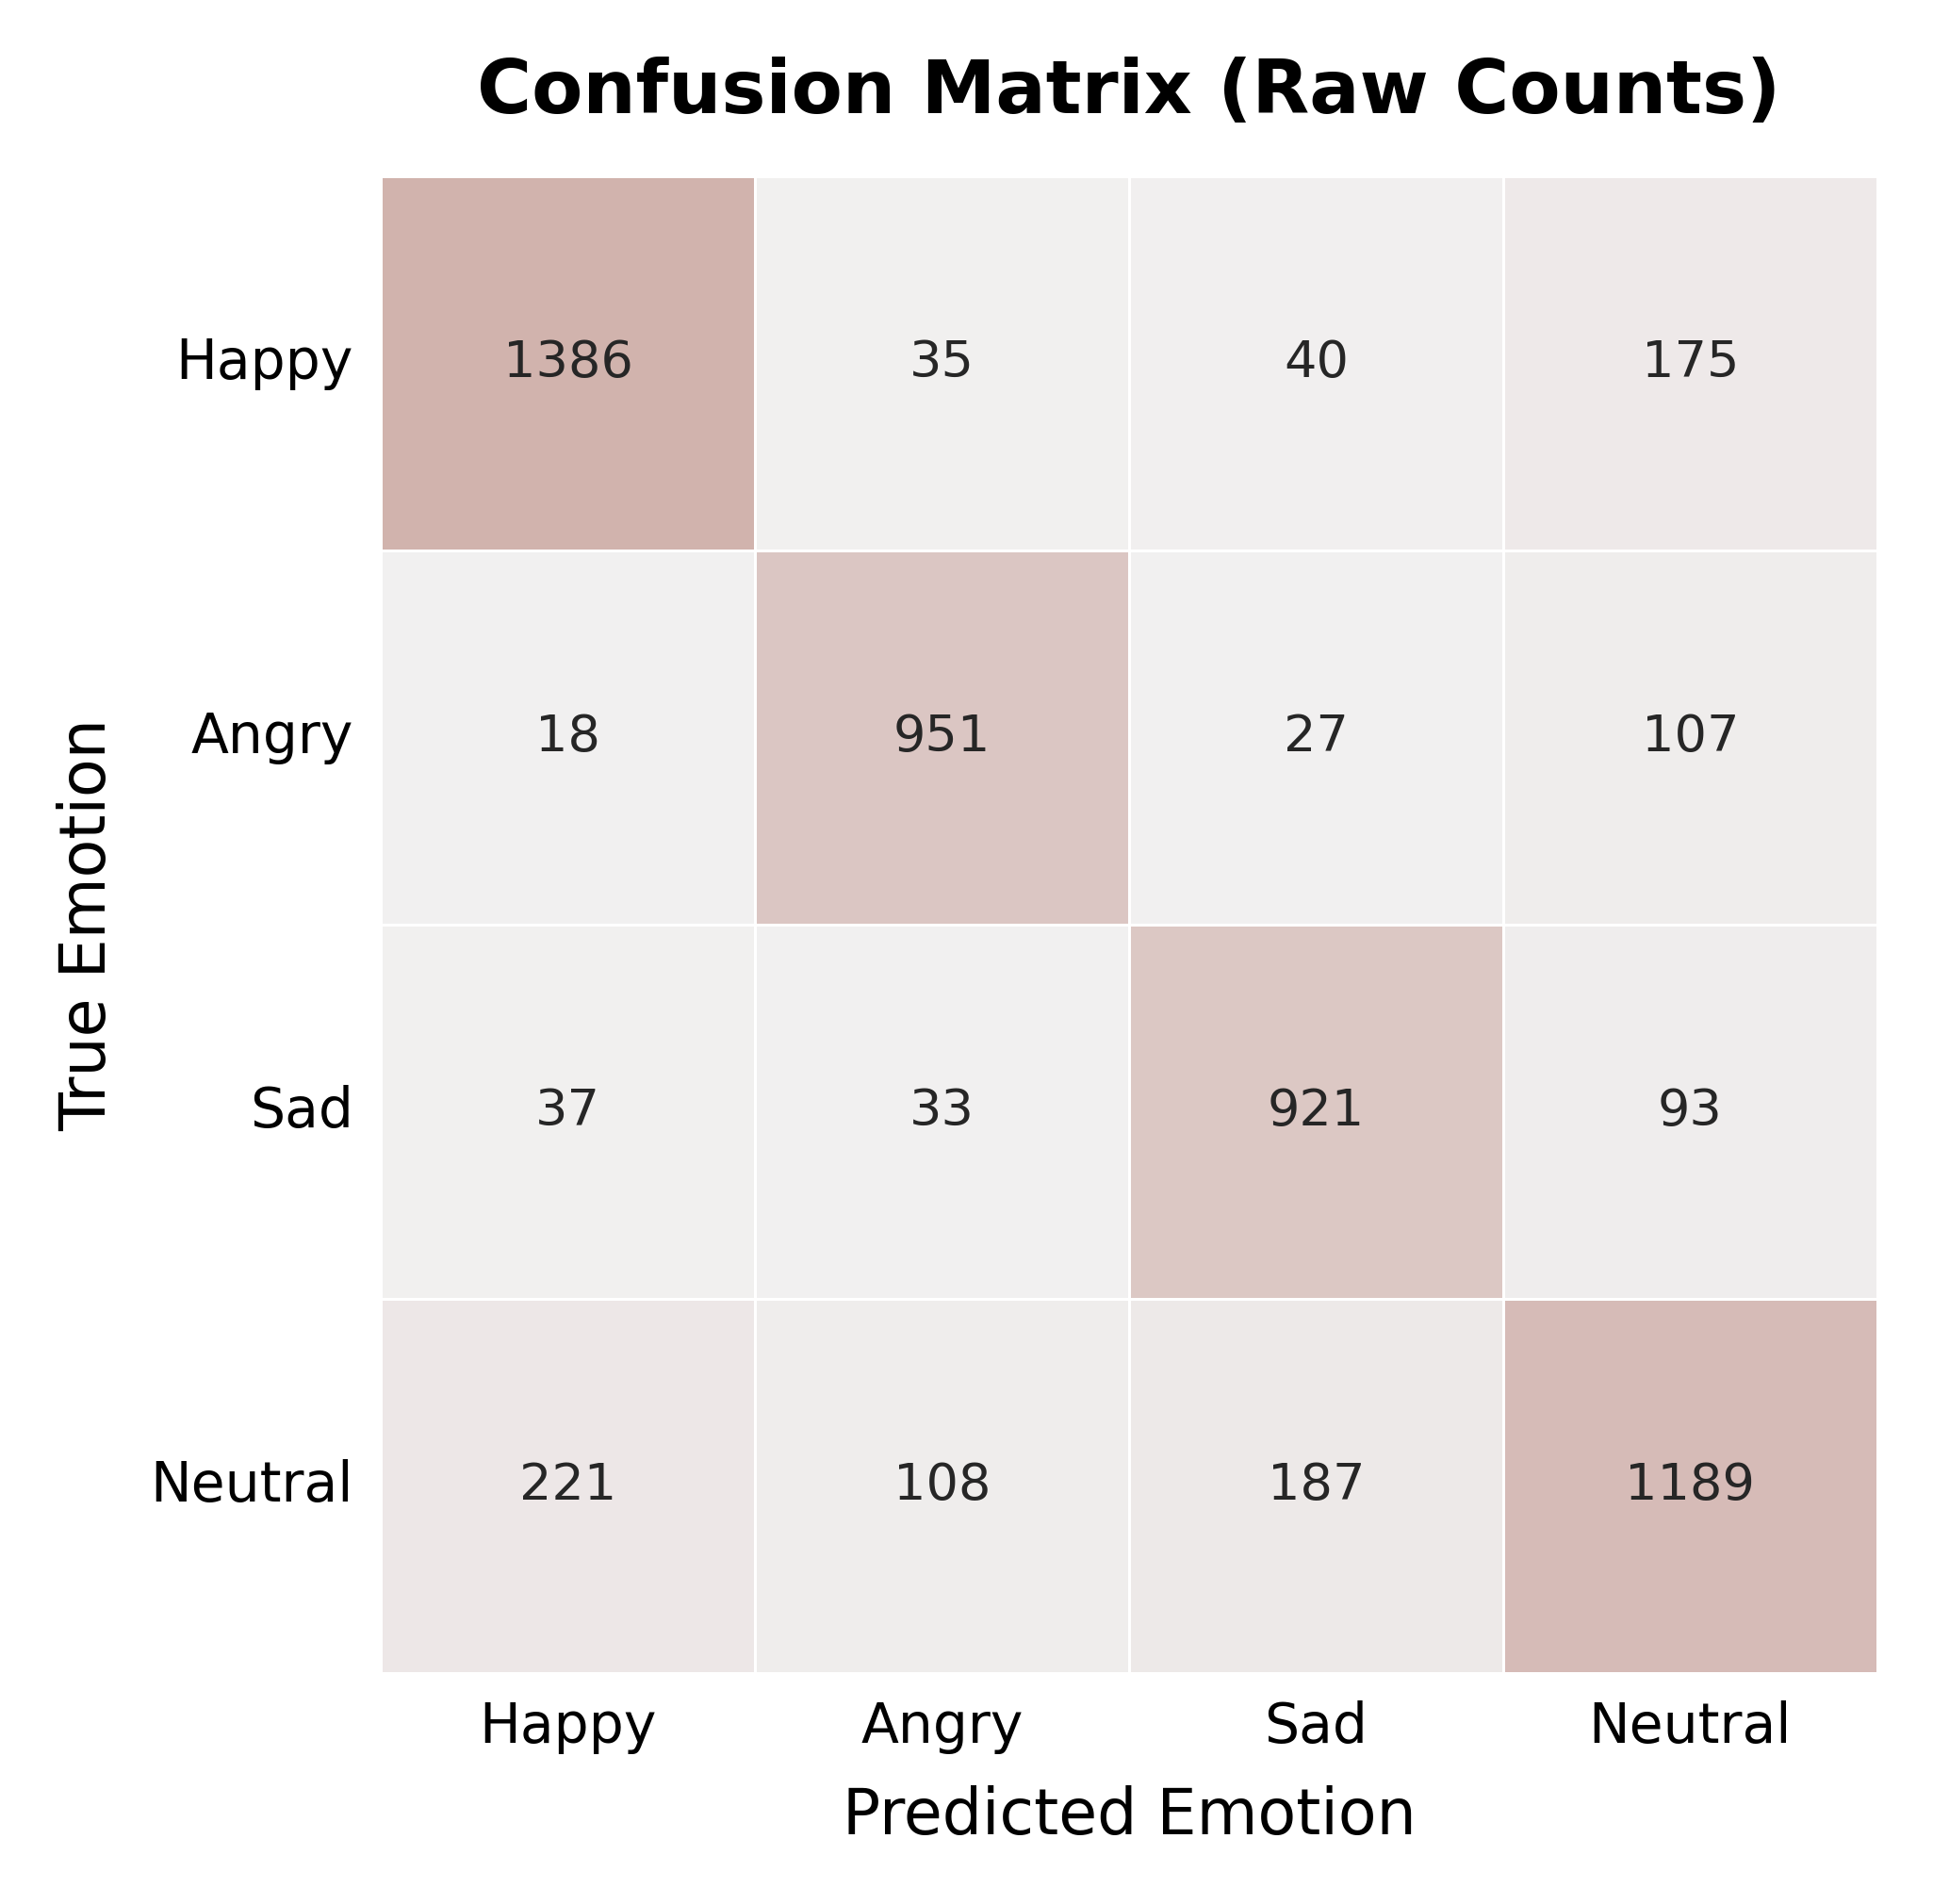

✅ Saved high-resolution figure to: figs/Figure5_Raw_ConfusionMatrix_Gated_Fusion_(E2V).png


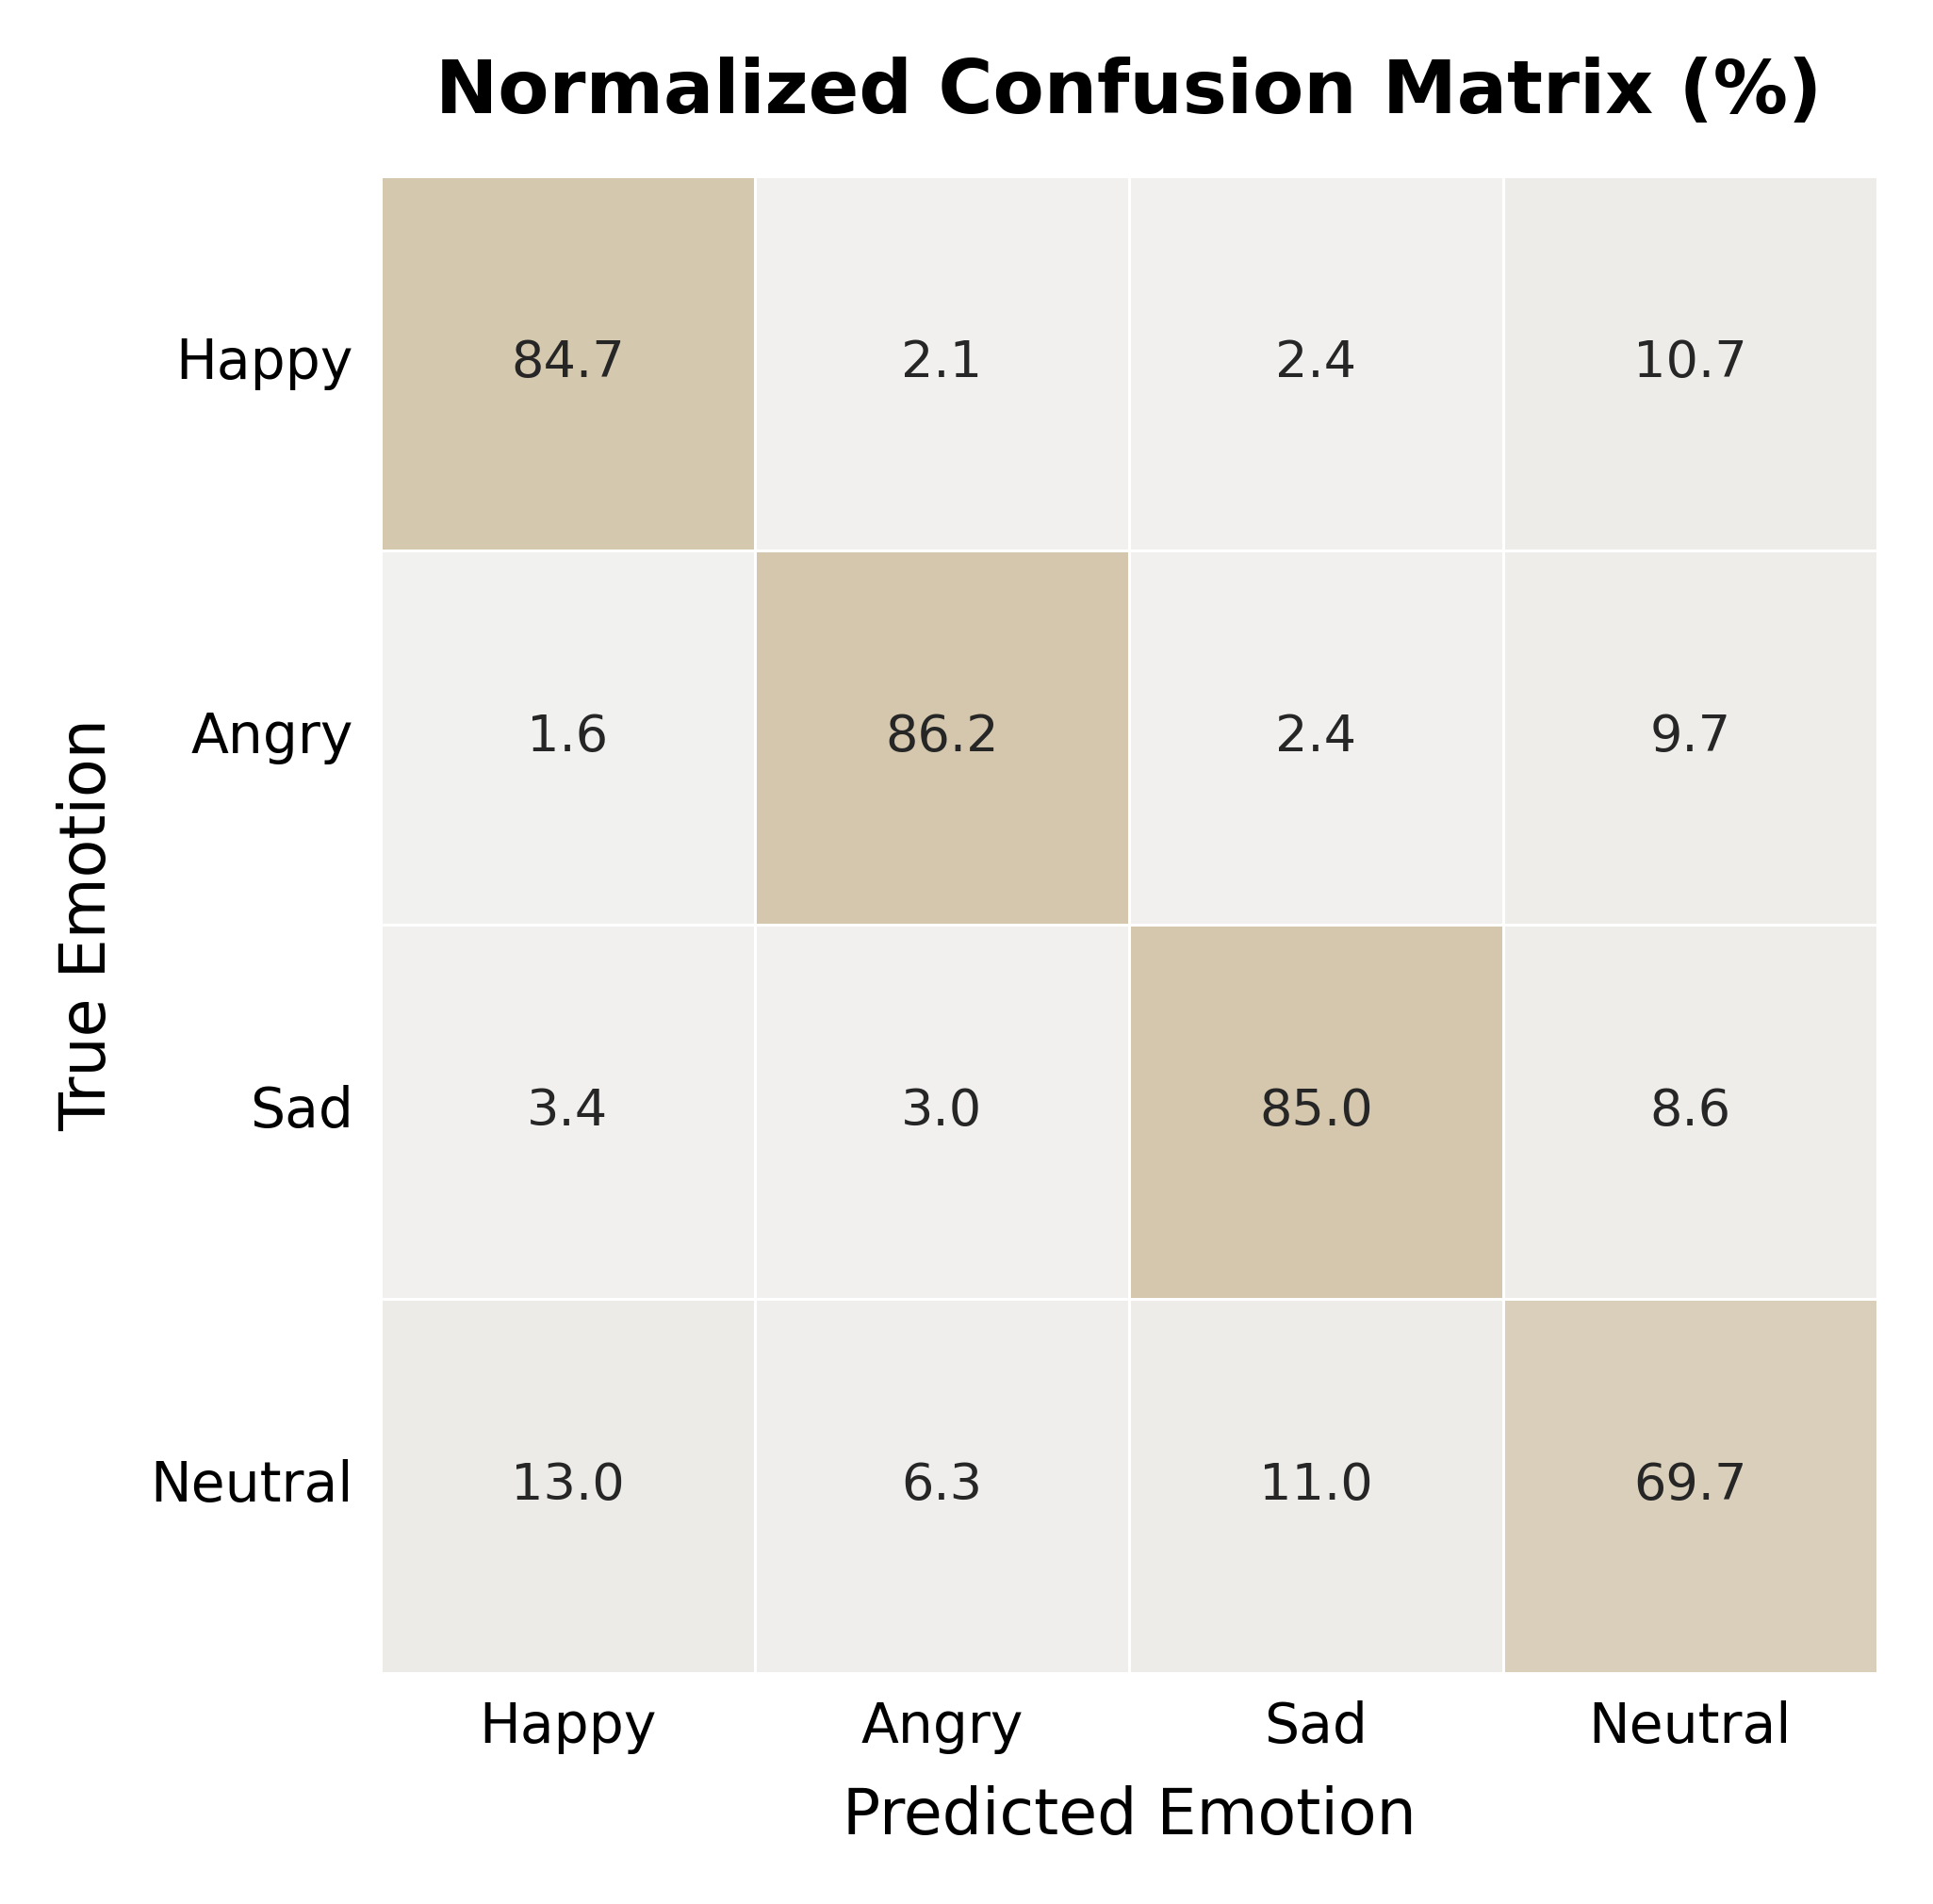

✅ Saved high-resolution figure to: figs/Figure5_Normalized_ConfusionMatrix_Gated_Fusion_(E2V).png


In [11]:
# ============================================================
# 📊 Cell 6.4 : Figure 5A & 5B (Paper Edition)
# ============================================================
# Confusion Matrix (Raw Counts) + Normalized Confusion Matrix (%)
# 输出为两张独立图，情绪标签替换数字 (Happy/Angry/Sad/Neutral)
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from matplotlib_inline.backend_inline import set_matplotlib_formats

# --- 统一科研绘图风格 ---
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8


def plot_confusion_matrix_single(y_true, y_pred, labels, normalize=False, model_name="GM-EPC"):
    """
    绘制单张混淆矩阵（Raw 或 Normalized）
    - normalize=False → 原始计数
    - normalize=True  → 百分比形式（显示 93.0 而不是 0.93）
    """
    os.makedirs("figs", exist_ok=True)

    #  数字标签 → 情绪标签映射
    id2emo = {0: "Happy", 1: "Angry", 2: "Sad", 3: "Neutral"}
    label_names = [id2emo.get(int(l), str(l)) for l in labels]

    #  计算混淆矩阵
    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true") * 100  # ← 乘以100显示百分比
    else:
        cm = confusion_matrix(y_true, y_pred, labels=labels)

    
    muted_rose = (0.82, 0.70, 0.68)  # 粉调 (Raw)
    beige_sand = (0.83, 0.78, 0.68)  # 米调 (Normalized)
    cmap = sns.light_palette(beige_sand if normalize else muted_rose, as_cmap=True, reverse=False)

    # 创建图像
    plt.figure(figsize=(3.3, 3.3))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".1f" if normalize else "d",  # ← 百分比显示1位小数
        cmap=cmap,
        cbar=False,
        square=True,
        linewidths=0.3,
        linecolor="white",
        annot_kws={"size":6.5}
    )

    #  标题与标签
    title = "Normalized Confusion Matrix (%)" if normalize else "Confusion Matrix (Raw Counts)"
    plt.title(title, fontsize=9.5, weight="bold", pad=10)
    plt.xlabel("Predicted Emotion", fontsize=8)
    plt.ylabel("True Emotion", fontsize=8)
    plt.xticks(ticks=np.arange(len(label_names)) + 0.5, labels=label_names, rotation=0, ha='center', fontsize=7)
    plt.yticks(ticks=np.arange(len(label_names)) + 0.5, labels=label_names, rotation=0, fontsize=7)

    #  去边框与网格
    ax = plt.gca()
    ax.tick_params(axis='both', which='both', length=0)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    plt.tight_layout(pad=0.4)

    #  保存高清图像
    fig_type = "Normalized" if normalize else "Raw"
    save_path = f"figs/Figure5_{fig_type}_ConfusionMatrix_{model_name.replace(' ', '_')}.png"
    plt.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.02)
    plt.show()

    print(f"Saved high-resolution figure to: {save_path}")


# --- 执行绘制 ---
unique_labels = sorted(list(set(global_data_for_analysis["labels"])))

# Figure 5A: 原始混淆矩阵
plot_confusion_matrix_single(
    global_data_for_analysis["labels"],
    global_data_for_analysis["preds"],
    unique_labels,
    normalize=False,
    model_name="Gated Fusion (E2V)"
)

# Figure 5B: 归一化混淆矩阵 (%)
plot_confusion_matrix_single(
    global_data_for_analysis["labels"],
    global_data_for_analysis["preds"],
    unique_labels,
    normalize=True,
    model_name="Gated Fusion (E2V)"
)


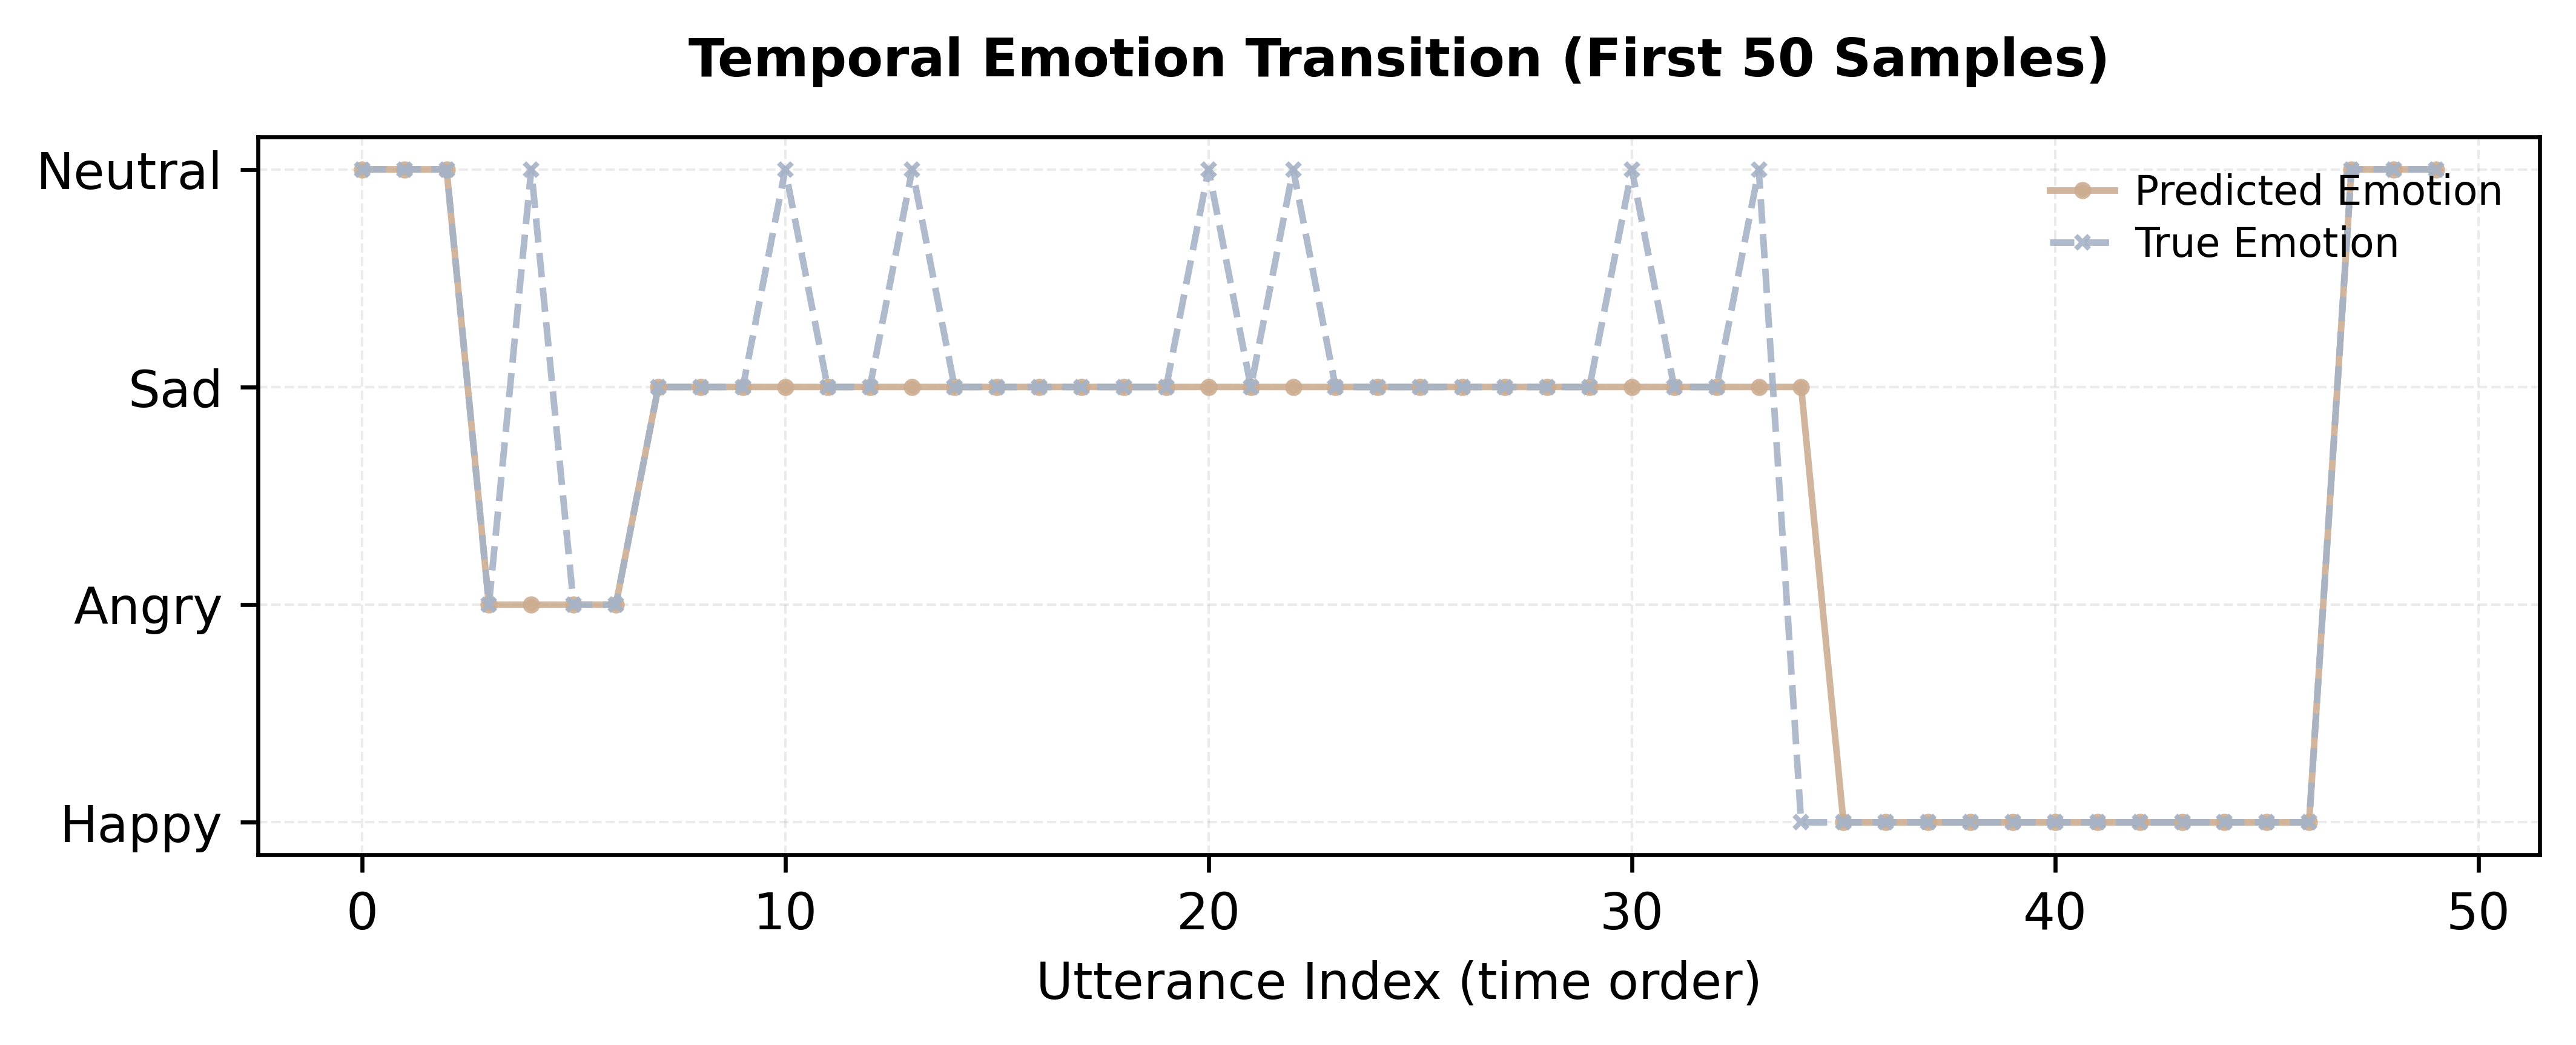

✅ Saved high-resolution figure to: figs/Figure7_TemporalTransition_Gated_Fusion_(E2V)_PaperEdition.png


In [24]:
# ============================================================
#  Cell 6.7 (Paper Edition): Temporal Emotion Transition Plot
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib_inline.backend_inline import set_matplotlib_formats

# --- 全局科研绘图风格统一 ---
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

def plot_temporal_transition(labels, preds, window=50, model_name="Gated Fusion (E2V)"):
    """
    绘制论文级的情绪时间序列变化曲线 (前50个样本)
    - 使用 Morandi 柔和配色
    - 区分预测 vs 真实标签的时间变化趋势
    - Y轴显示真实情绪名称 (Happy / Angry / Sad / Neutral)
    """
    os.makedirs("figs", exist_ok=True)

    #  Morandi 色系
    morandi_blue = (0.65, 0.70, 0.78)     # 柔和蓝灰
    morandi_orange = (0.80, 0.68, 0.57)   # 柔和橙褐

    #  情绪映射表（与 dataset.py 一致）
    id2emo = {0: "Happy", 1: "Angry", 2: "Sad", 3: "Neutral"}
    emo_order = ["Happy", "Angry", "Sad", "Neutral"]  # 固定顺序保持一致性

    #  限制窗口范围
    labels = np.array(labels[:window])
    preds = np.array(preds[:window])

    # --- 绘图 ---
    plt.figure(figsize=(7.0, 2.8))  # 单栏宽度×2，较长条形
    plt.plot(
        range(len(preds)),
        preds,
        label="Predicted Emotion",
        color=morandi_orange,
        linewidth=1.3,
        alpha=0.9,
        linestyle="-",
        marker="o",
        markersize=2.4
    )
    plt.plot(
        range(len(labels)),
        labels,
        label="True Emotion",
        color=morandi_blue,
        linewidth=1.3,
        alpha=0.9,
        linestyle="--",
        marker="x",
        markersize=2.7
    )

    plt.title("Temporal Emotion Transition (First 50 Samples)", fontsize=10.5, weight="bold", pad=12)
    plt.xlabel("Utterance Index (time order)", fontsize=10)
    # plt.ylabel("Emotion Category", fontsize=8)
    
    plt.xticks(fontsize=10)   # ← 控制 X 轴数字的大小
    #  替换 Y 轴标签为真实情绪
    plt.yticks(
        ticks=np.arange(len(emo_order)),
        labels=emo_order,
        fontsize=10,
        rotation=0
    )

    #  格式优化
    plt.grid(True, alpha=0.25, linestyle="--", linewidth=0.5)
    plt.legend(
        loc="upper right",
        fontsize=8,
        frameon=False,
        labelspacing=0.3,
        handlelength=1.6,
        handletextpad=0.5
    )
    plt.tight_layout(pad=0.5)

    #  保存高清图像
    save_path = f"figs/Figure7_TemporalTransition_{model_name.replace(' ', '_')}_PaperEdition.png"
    plt.savefig(save_path, dpi=600, bbox_inches="tight", pad_inches=0.02)
    plt.show()

    print(f"Saved high-resolution figure to: {save_path}")


# --- 执行绘制 ---
plot_temporal_transition(
    global_data_for_analysis["labels"],
    global_data_for_analysis["preds"],
    window=50,
    model_name="Gated Fusion (E2V)"
)
